# Store Sales - Time Series Forecasting
#### Author: James Coffey
#### Date: 2025-08-19
#### Challenge URL: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

# Imports & settings

In [ ]:
import math
import warnings
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from scipy.signal import periodogram
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_ccf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

In [ ]:
def flatten_cols(cols):
    """Flatten possibly-MultiIndex columns into strings."""
    if isinstance(cols, pd.MultiIndex):
        return ["__".join(map(str, tup)) for tup in cols]
    return list(cols)

def ensure_daily_timestamp_index(s: pd.Series) -> pd.Series:
    """Convert Period/Timestamp index to daily Timestamp freq for signal ops."""
    idx = s.index
    idx = idx.to_timestamp() if isinstance(idx, pd.PeriodIndex) else pd.to_datetime(idx)
    return pd.Series(s.values, index=idx, name=s.name).asfreq("D")

def zscore_cols(df: pd.DataFrame) -> pd.DataFrame:
    mu = df.mean(axis=0)
    sd = df.std(axis=0, ddof=0).replace(0, np.nan)
    return (df - mu) / sd

def match_key_in_index_like(key, candidates):
    m = {str(c): c for c in candidates}
    if str(key) not in m:
        raise KeyError(f"{key!r} not found. First few: {list(m)[:10]}")
    return m[str(key)]

def make_wide_target(store_sales_df: pd.DataFrame) -> pd.DataFrame:
    """date x (store_nbr, family) wide target matrix."""
    return store_sales_df["sales"].unstack(["store_nbr", "family"]).sort_index()

def make_dp(index, *, order=2, weekly=False, freq="A", fourier_order=None, forecast=None) -> pd.DataFrame:
    add = [CalendarFourier(freq=freq, order=fourier_order)] if fourier_order else []
    dp = DeterministicProcess(
        index=index, constant=False, order=order,
        seasonal=weekly, additional_terms=add, drop=True
    )
    if forecast:
        return dp.in_sample(), dp.out_of_sample(steps=forecast)
    return dp.in_sample()

def make_lags(ts, lags, *, name):
    """Generic lag builder for Series or DataFrame."""
    return pd.concat({f"{name}_lag_{i}": ts.shift(i) for i in range(1, lags + 1)}, axis=1)

def make_early_stopping_callback(patience=3, min_delta=0.0):
    """
    Stops the study if best value hasn't improved by at least `min_delta`
    for `patience` consecutive trials.
    """

    def _callback(study, trial):
        # Best value after this trial:
        best = study.best_value

        # What was the best before this trial?
        prev_best = study.user_attrs.get("prev_best_value", float("inf"))
        no_improve = study.user_attrs.get("no_improve_count", 0)

        # Check improvement
        if best < prev_best - min_delta:
            study.set_user_attr("prev_best_value", best)
            study.set_user_attr("no_improve_count", 0)
        else:
            no_improve += 1
            study.set_user_attr("no_improve_count", no_improve)
            if no_improve >= patience:
                print(
                    f"[Early stop] No improvement in {patience} consecutive trials. "
                    f"Best RMSLE so far: {best:.6f}"
                )
                study.stop()

    return _callback

def fit_ridge_with_optuna(X_train, y_train, X_valid, y_valid, *,
                          alpha_lo, alpha_hi, patience=12, seed=SEED):
    """Tune Ridge alpha with Optuna; return fitted pipeline and the study."""

    substrings = [
        'trend', 'trend_squared', 'sin(', 'cos(',
        'y_lag_', 'tx_lag_', 'oil_', 'additional', 'days_from_'
    ]
    num_cols = [c for c in X_train.columns if any(s in c for s in substrings)]
    dum_cols = [c for c in X_train.columns if c.startswith('s(')]  # weekly one-hots
    evt_cols = [c for c in X_train.columns if c not in num_cols and c not in dum_cols]

    def objective(trial):
        alpha = trial.suggest_float("alpha", alpha_lo, alpha_hi, log=True)
        num_pipe = Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale',  StandardScaler()),
        ])
        
        prep = ColumnTransformer([
            ('num', num_pipe, num_cols),
            ('dum', 'passthrough', dum_cols),   # or use num_pipe if you prefer scaling dummies
            ('evt', 'passthrough', evt_cols),
        ], remainder='drop')
        
        pipe = Pipeline([
            ('prep', prep),
            ('ridge', Ridge(alpha=alpha, fit_intercept=True, random_state=seed)),
        ])
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_valid)
        rmsle = mean_squared_log_error(y_valid.clip(lower=0), np.clip(pred, 0, None))**0.5
        trial.set_user_attr("rmse", float(mean_squared_error(y_valid, pred, squared=False)))
        return rmsle

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=seed))
    study.optimize(objective, n_trials=40, callbacks=[make_early_stopping_callback(patience=patience, min_delta=0.0)])
    best_alpha = study.best_params["alpha"]
    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale',  StandardScaler()),
    ])
    
    prep = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('dum', 'passthrough', dum_cols),   # or use num_pipe if you prefer scaling dummies
        ('evt', 'passthrough', evt_cols),
    ], remainder='drop')
    
    best_pipe = Pipeline([
        ('prep', prep),
        ('ridge', Ridge(alpha=best_alpha, fit_intercept=True, random_state=seed)),
    ]).fit(X_train, y_train)
    return best_pipe, study

In [3]:
BASE_DIR = "/kaggle/input/store-sales-time-series-forecasting"

store_sales = pd.read_csv(
    f"{BASE_DIR}/train.csv",
    usecols=["store_nbr", "family", "date", "sales", "onpromotion"],
    dtype={
        "store_nbr": "category",
        "family": "category",
        "sales": "float32",
        "onpromotion": "uint32",
    },
    parse_dates=["date"],
    infer_datetime_format=True,
)
store_sales["date"] = store_sales.date.dt.to_period("D")

In [4]:
store_sales = store_sales.set_index(["store_nbr", "family", "date"]).sort_index()

Text(0, 0.5, 'Sales (rolling mean)')

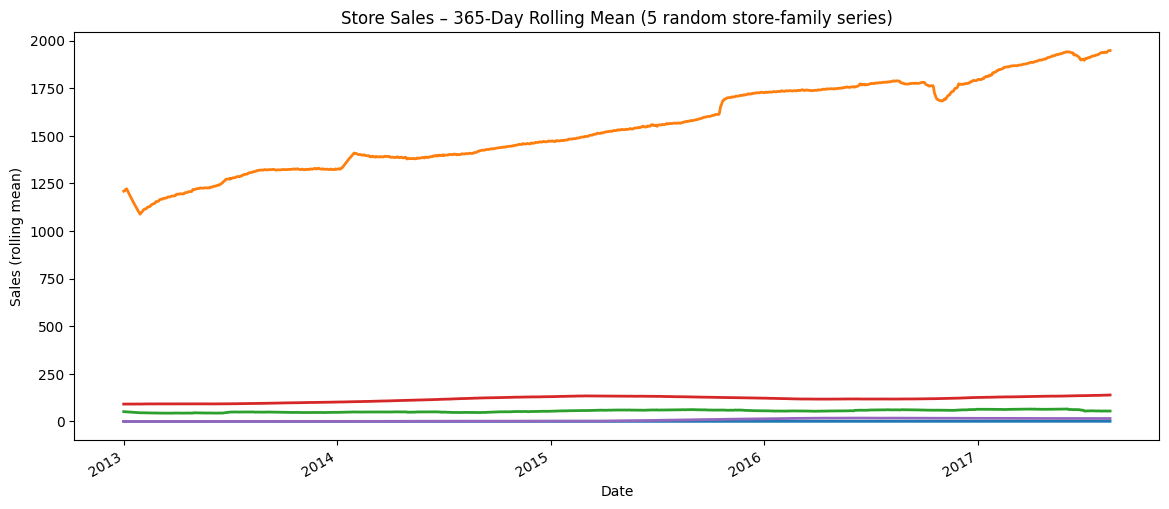

In [5]:
# 1) sample 5 random (store, family) pairs
pairs = store_sales.index.droplevel("date").unique()  # MultiIndex of (store, family)
rng = np.random.default_rng(42)  # change/remove seed for new draw
sel_pairs = pairs.take(rng.choice(len(pairs), size=5, replace=False))

# 2) filter rows for those pairs (all dates)
mask = store_sales.index.droplevel("date").isin(sel_pairs)
subset = store_sales.loc[mask, "sales"]  # Series with 3-level index

# 3) pivot wide: index=date, cols=(store, family)
to_plot = subset.unstack(["store_nbr", "family"]).sort_index()
to_plot.index = to_plot.index.to_timestamp()  # optional; makes plotting nicer

# 4) 365-day centered rolling mean
ma365 = to_plot.rolling(
    window=365,  # 365-day window
    center=True,  # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()  # compute the mean (could also do median, std, min, max, ...)

# 5) pretty column names and plot (no legend)
ma365.columns = [f"{s}-{f}" for (s, f) in ma365.columns]
ax = ma365.plot(figsize=(14, 6), linewidth=2, legend=False)
ax.set_title("Store Sales – 365-Day Rolling Mean (5 random store-family series)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales (rolling mean)")

In [6]:
# Wide target & DP features
y = make_wide_target(store_sales)                # (unchanged intent)
X = make_dp(y.index, order=2, weekly=False)      # trend-only first pass

# Split
idx_train = y.index < "2017-01-01"
idx_valid = ~idx_train

# ---- Trend-only Ridge (alpha in [1e3, 1e4]) ----
ridge_trend, study_trend = fit_ridge_with_optuna(
    X.loc[idx_train], y.loc[idx_train],
    X.loc[idx_valid], y.loc[idx_valid],
    alpha_lo=1e3, alpha_hi=1e4, patience=12
)
y_trend = pd.DataFrame(ridge_trend.predict(X), index=y.index, columns=y.columns)

[I 2025-08-29 00:11:38,381] A new study created in memory with name: no-name-3c013fa2-eee7-497b-80c7-7488759e2d8d
[I 2025-08-29 00:11:38,506] Trial 0 finished with value: 0.7798799213182244 and parameters: {'alpha': 2368.863950364079}. Best is trial 0 with value: 0.7798799213182244.
[I 2025-08-29 00:11:38,647] Trial 1 finished with value: 0.79194256630739 and parameters: {'alpha': 8927.180304353626}. Best is trial 0 with value: 0.7798799213182244.
[I 2025-08-29 00:11:38,790] Trial 2 finished with value: 0.7817396029179825 and parameters: {'alpha': 5395.030966670228}. Best is trial 0 with value: 0.7798799213182244.
[I 2025-08-29 00:11:38,939] Trial 3 finished with value: 0.778751521386065 and parameters: {'alpha': 3968.7933304443736}. Best is trial 3 with value: 0.778751521386065.
[I 2025-08-29 00:11:39,108] Trial 4 finished with value: 0.7866305474315952 and parameters: {'alpha': 1432.2493718230244}. Best is trial 3 with value: 0.778751521386065.
[I 2025-08-29 00:11:39,239] Trial 5 fin

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.778301


Best params: {'alpha': 3325.7344596125563}
Best RMSLE: 0.7783008939971782
Best RMSE : 173.26518951197176


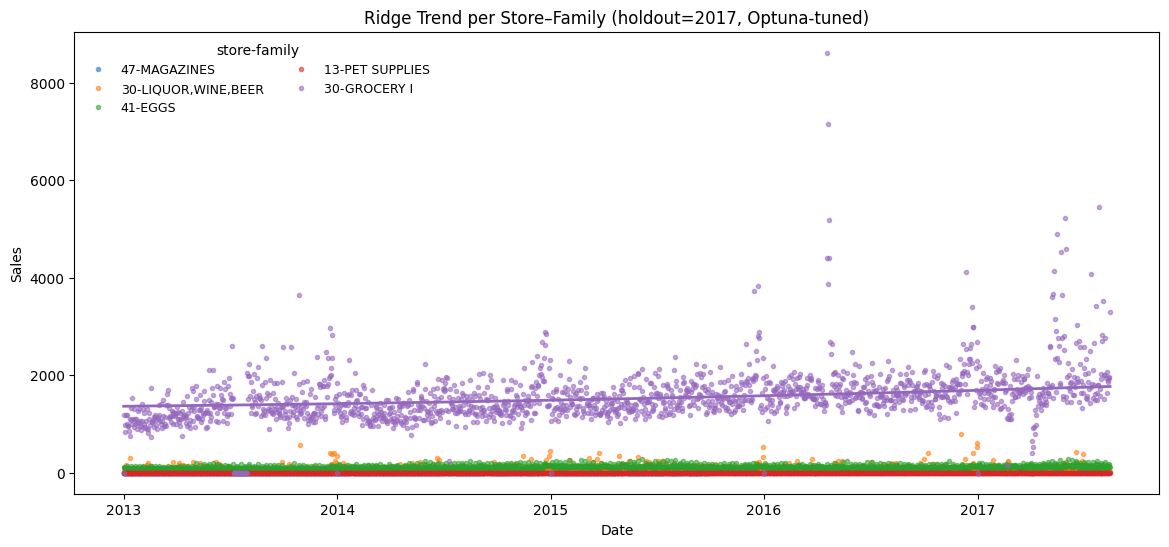

In [7]:
print("Best params:", study_trend.best_params)
print("Best RMSLE:", study_trend.best_value)
print("Best RMSE :", study_trend.best_trial.user_attrs["rmse"])

# Plot 5 random store–family combos: dots (actuals) + line (Ridge trend)
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    trend = y_trend[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(t_index, trend.values, linewidth=2, color=pts.get_color())

ax.set_title("Ridge Trend per Store–Family (holdout=2017, Optuna-tuned)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(title="store-family", ncol=2, frameon=False, fontsize=9)
plt.show()

# Seasonality

In [8]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend="linear", ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling="spectrum",
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

## Build residuals (global & per-series)

In [9]:
# y and y_trend from your EN/MTEN pipeline (wide, index = Period[D], cols=(store,family))
y_resid = y - y_trend

# global daily median residual across all series
resid_median = y_resid.median(axis=1).dropna()

## Weekly seasonal plot on residuals

<Axes: title={'center': 'Seasonal Plot (week/day)'}, xlabel='day', ylabel='resid'>

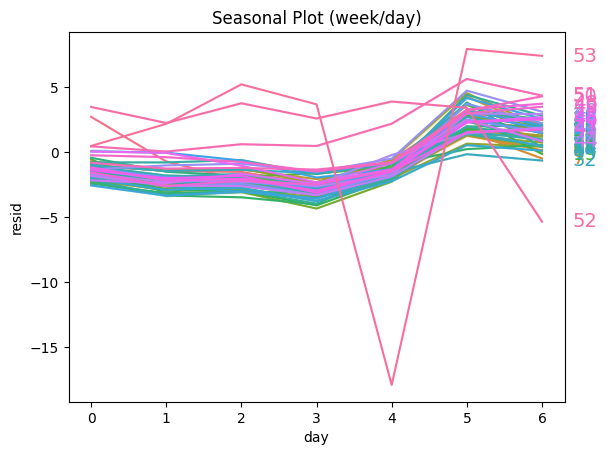

In [10]:
# Build features for the helper
s = resid_median.copy()
t = s.index.to_timestamp()

X_week = pd.DataFrame(
    {
        "week": t.isocalendar().week.astype(int).to_numpy(),
        "day": t.dayofweek.to_numpy(),
        "resid": s.to_numpy(),
    },
    index=t,
)

# Weekly seasonality: period='week', freq='day'
seasonal_plot(X_week, y="resid", period="week", freq="day")

## Periodogram on residuals (don’t double-detrend)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

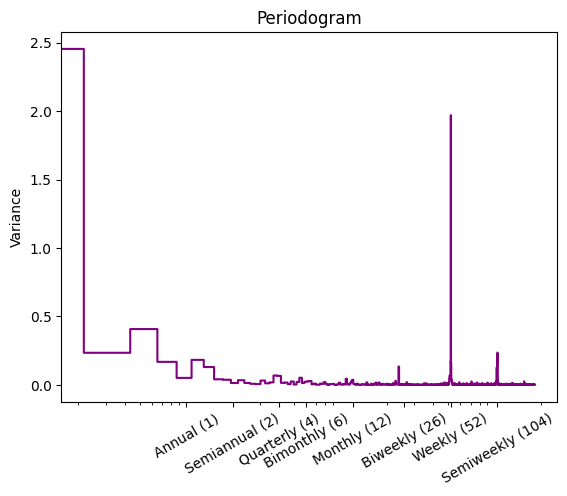

In [11]:
# For residuals, trend is already removed; use detrend='constant' (or None)
plot_periodogram(resid_median, detrend="constant")

## Fit Trend and Seasonality

In [12]:
# Fourier + weekly seasonal DP
X_seasonal, X_forecast = make_dp(y.index, order=2, weekly=True, freq="A", fourier_order=12, forecast=16) # I will use forecast for predicting test values
ridge_seas, study_seas = fit_ridge_with_optuna(
    X_seasonal.loc[idx_train], y.loc[idx_train],
    X_seasonal.loc[idx_valid], y.loc[idx_valid],
    alpha_lo=1e3, alpha_hi=1e4, patience=12
)
y_trend = pd.DataFrame(ridge_seas.predict(X_seasonal), index=y.index, columns=y.columns)
X = X_seasonal  # keep going from this design matrix

[I 2025-08-29 00:11:51,348] A new study created in memory with name: no-name-a26d075a-ed73-4939-83d7-623fff59452b
[I 2025-08-29 00:11:51,496] Trial 0 finished with value: 0.7798799213182244 and parameters: {'alpha': 2368.863950364079}. Best is trial 0 with value: 0.7798799213182244.
[I 2025-08-29 00:11:51,623] Trial 1 finished with value: 0.79194256630739 and parameters: {'alpha': 8927.180304353626}. Best is trial 0 with value: 0.7798799213182244.
[I 2025-08-29 00:11:51,767] Trial 2 finished with value: 0.7817396029179825 and parameters: {'alpha': 5395.030966670228}. Best is trial 0 with value: 0.7798799213182244.
[I 2025-08-29 00:11:51,905] Trial 3 finished with value: 0.778751521386065 and parameters: {'alpha': 3968.7933304443736}. Best is trial 3 with value: 0.778751521386065.
[I 2025-08-29 00:11:52,044] Trial 4 finished with value: 0.7866305474315952 and parameters: {'alpha': 1432.2493718230244}. Best is trial 3 with value: 0.778751521386065.
[I 2025-08-29 00:11:52,183] Trial 5 fin

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.778301


Best params: {'alpha': 3325.7344596125563}
Best RMSLE: 0.7783008939971782
Best RMSE : 173.26518951197176


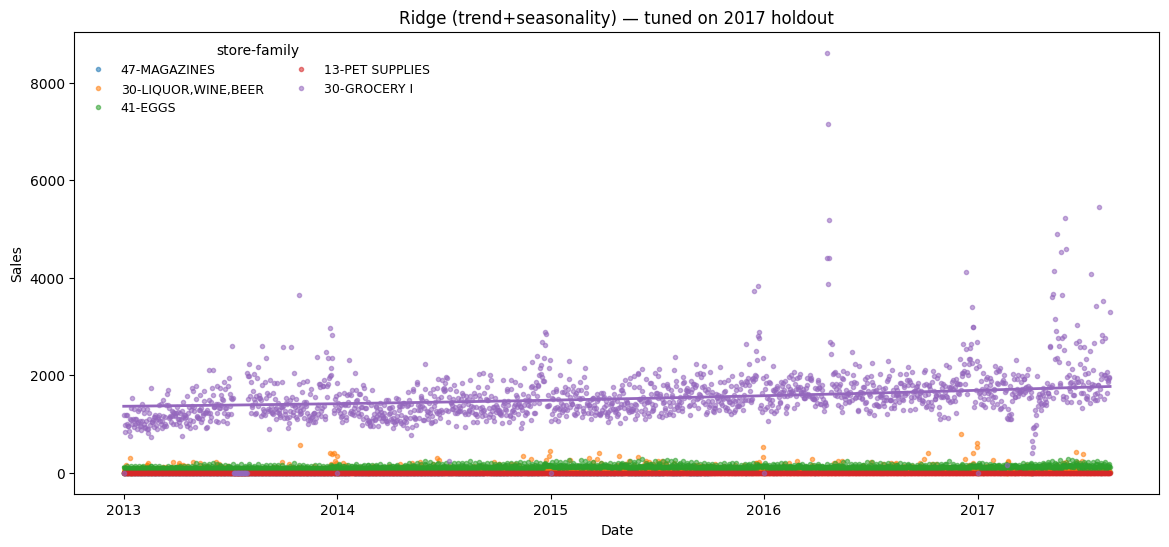

In [13]:
print("Best params:", study_seas.best_params)
print("Best RMSLE:", study_seas.best_value)
print("Best RMSE :", study_seas.best_trial.user_attrs["rmse"])

# Plot 5 random store–family combos: dots (actuals) + line (Ridge trend)
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    trend = y_trend[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(t_index, trend.values, linewidth=2, color=pts.get_color())

ax.set_title("Ridge (trend+seasonality) — tuned on 2017 holdout")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(title="store-family", ncol=2, frameon=False, fontsize=9)
plt.show()

## Check for remaining seasonality

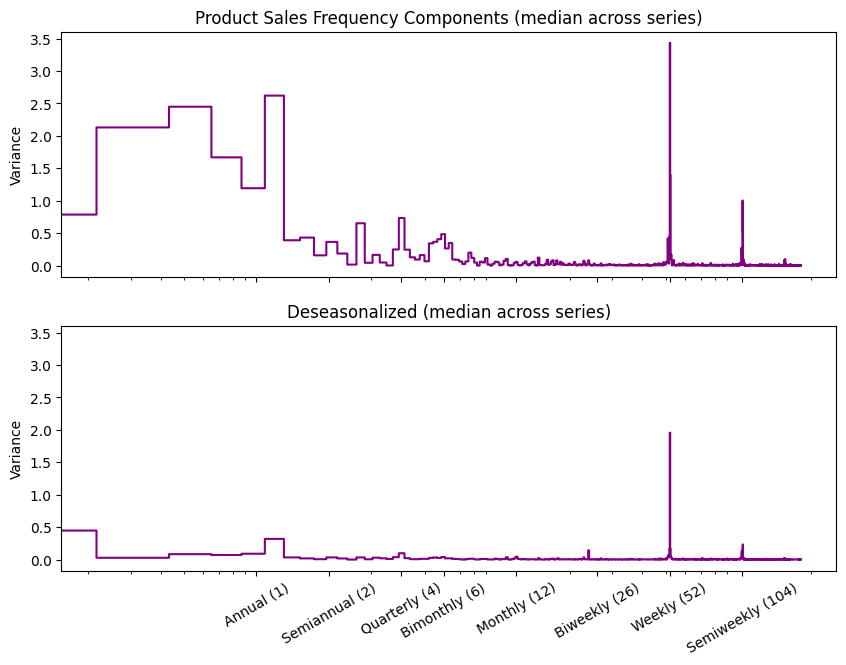

In [14]:
# y and y_trend from your EN/MTEN pipeline (wide, index = Period[D], cols=(store,family))
y_deseason = y - y_trend

# global daily median across all series
y_median = y.median(axis=1).dropna()
deseason_median = y_deseason.median(axis=1).dropna()

# For residuals, trend is already removed; use detrend='constant' (or None)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_median, detrend="linear", ax=ax1)
ax1.set_title("Product Sales Frequency Components (median across series)")
ax2 = plot_periodogram(deseason_median, detrend="linear", ax=ax2)
ax2.set_title("Deseasonalized (median across series)");

## Handle Holidays and Other One-Hot Encodings

### Holiday Data

In [15]:
holidays = pd.read_csv(
    f"{BASE_DIR}/holidays_events.csv",
    usecols=["date", "type", "locale", "locale_name", "description", "transferred"],
    dtype={
        "type": "category",
        "locale": "category",
        "locale_name": "category",
        "description": "category",
        "transferred": "bool",
    },
    parse_dates=["date"],
)
holidays["date"] = holidays.date.dt.to_period("D")
holidays = holidays.set_index("date").sort_index()

# Normalize description (strip leading 'Traslado ' / 'Puente ')
holidays["description"] = pd.Categorical(
    holidays["description"].astype("string").str.replace(r"^\s*(Traslado|Puente)\s+", "", case=False, regex=True)
)

# Keep observed dates; drop original moved dates
# (drop rows where 'transferred' is True)
holidays = holidays[~holidays["transferred"]].drop(columns="transferred")

# Collapse Transfer/Bridge to Holiday
holidays.loc[holidays["type"].isin(["Transfer", "Bridge"]), "type"] = "Holiday"

# Work Day naming
holidays["description"] = holidays["description"].cat.add_categories(["Work Day"])
holidays.loc[holidays["type"].eq("Work Day"), "description"] = "Work Day"

# Signed offsets ±N at end of description
holidays["additional"] = (
    pd.to_numeric(
        holidays["description"].astype("string").str.extract(r"([+-]\d+)$", expand=False),
        errors="coerce",
    )
    .fillna(0)
    .astype("int16")
)
holidays["additional_squared"] = (holidays["additional"].astype("int32") ** 2).astype("int32")

# Strip the trailing ±N
holidays["description"] = pd.Categorical(
    holidays["description"].astype("string").str.replace(r"[+-]\d+$", "", regex=True).str.strip()
)

# Map specific groups
holidays["description"] = holidays["description"].cat.add_categories(["Shopping Day", "Disaster", "World Cup", "Local", "Regional"])
holidays.loc[holidays["description"].isin(["Cyber Monday", "Black Friday"]), "description"] = "Shopping Day"
holidays.loc[holidays["description"].eq("Terremoto Manabi"), "description"] = "Disaster"
holidays.loc[
    holidays["description"].astype("string").str.contains(r"Mundial de f[uú]tbol", case=False, na=False),
    "description",
] = "World Cup"

# Collapse by locale to Local/Regional group labels
holidays.loc[holidays["locale"].eq("Local"), "description"] = "Local"
holidays.loc[holidays["locale"].eq("Regional"), "description"] = "Regional"

# Drop unused
holidays = holidays.drop(columns=["locale"])
holidays["description"] = holidays["description"].cat.remove_unused_categories()

# --- National events matrix ---
disaster = holidays.loc[holidays["description"] == "Disaster"].copy()
disaster["Disaster"] = 1.0
disaster = disaster.rename(columns={"additional": "days_from_dis", "additional_squared": "days_from_dis_squared"})

national = holidays.loc[(holidays["locale_name"] == "Ecuador") & (holidays["description"] != "Disaster")]
national_events = pd.concat(
    [
        pd.get_dummies(national["description"].cat.remove_unused_categories(), dtype=float),
        national[["additional", "additional_squared"]].astype(float),
    ],
    axis=1,
)
national_events = national_events.join(disaster[["Disaster", "days_from_dis", "days_from_dis_squared"]], how="outer").fillna(0.0)

# Drop duplicate dates, but keep the one with the highest absolute value of 'additional'
national_events["abs_add"] = national_events["additional"].abs() # helper magnitude for tie-breaking
national_events = national_events.reset_index().sort_values(["date", "abs_add"]).drop_duplicates("date", keep="last").drop(columns="abs_add").set_index("date")

### Store Data

In [16]:
stores = pd.read_csv(
    f"{BASE_DIR}/stores.csv",
    usecols=["store_nbr", "city", "state", "type", "cluster"],
    dtype={
        "store_nbr": "category",
        "city": "category",
        "state": "category",
        "type": "category",
        "cluster": "category",
    },
)
stores = stores.set_index(["store_nbr"]).sort_index()
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
10,Quito,Pichincha,C,15
11,Cayambe,Pichincha,B,6
12,Latacunga,Cotopaxi,C,15
13,Latacunga,Cotopaxi,C,15


### Incorporate National Events into Train Data

In [17]:
X = X.join(national_events, how='left').fillna(0.0)

### Train while capturing Trend, Seasonality, and Holidays

In [18]:
# After joining national_events (and any other features you add)
ridge_hol, study_hol = fit_ridge_with_optuna(
    X.loc[idx_train], y.loc[idx_train],
    X.loc[idx_valid], y.loc[idx_valid],
    alpha_lo=1e3, alpha_hi=1e4, patience=12
)
y_trend = pd.DataFrame(ridge_hol.predict(X), index=y.index, columns=y.columns)

[I 2025-08-29 00:11:57,772] A new study created in memory with name: no-name-4f4e45b6-fd04-4fea-87a2-501218f2a9fa
[I 2025-08-29 00:11:57,913] Trial 0 finished with value: 0.7758185763318299 and parameters: {'alpha': 2368.863950364079}. Best is trial 0 with value: 0.7758185763318299.
[I 2025-08-29 00:11:58,067] Trial 1 finished with value: 0.7930221519381073 and parameters: {'alpha': 8927.180304353626}. Best is trial 0 with value: 0.7758185763318299.
[I 2025-08-29 00:11:58,221] Trial 2 finished with value: 0.7816135820445794 and parameters: {'alpha': 5395.030966670228}. Best is trial 0 with value: 0.7758185763318299.
[I 2025-08-29 00:11:58,377] Trial 3 finished with value: 0.7774016784495293 and parameters: {'alpha': 3968.7933304443736}. Best is trial 0 with value: 0.7758185763318299.
[I 2025-08-29 00:11:58,526] Trial 4 finished with value: 0.7800017716156638 and parameters: {'alpha': 1432.2493718230244}. Best is trial 0 with value: 0.7758185763318299.
[I 2025-08-29 00:11:58,674] Trial 

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.775591


Best params: {'alpha': 2723.59125259362}
Best RMSLE: 0.7755906890711565
Best RMSE : 172.64450046676163


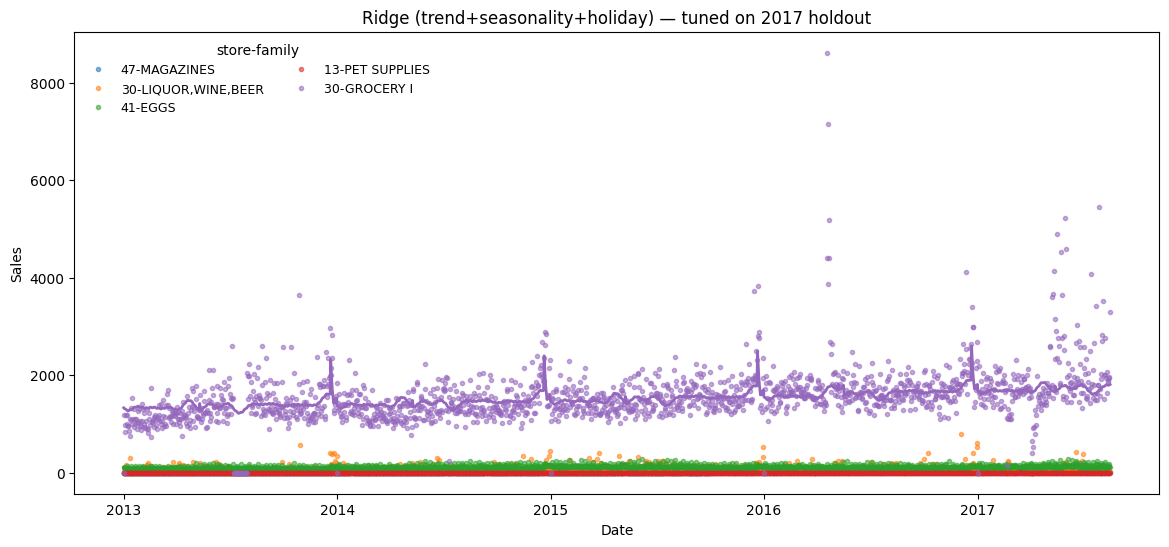

In [19]:
print("Best params:", study_hol.best_params)
print("Best RMSLE:", study_hol.best_value)
print("Best RMSE :", study_hol.best_trial.user_attrs["rmse"])

# Plot 5 random store–family combos: dots (actuals) + line (Ridge trend)
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    trend = y_trend[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(t_index, trend.values, linewidth=2, color=pts.get_color())

ax.set_title("Ridge (trend+seasonality+holiday) — tuned on 2017 holdout")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(title="store-family", ncol=2, frameon=False, fontsize=9)
plt.show()

# Cycles

## Partial Autocorrelation

In [20]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(
        color="C3",
    )
    ax = sns.regplot(
        x=x_,
        y=y_,
        scatter_kws=scatter_kws,
        line_kws=line_kws,
        lowess=True,
        ax=ax,
        **kwargs,
    )
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault("nrows", nrows)
    kwargs.setdefault("ncols", math.ceil(lags / nrows))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs["nrows"] * kwargs["ncols"])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

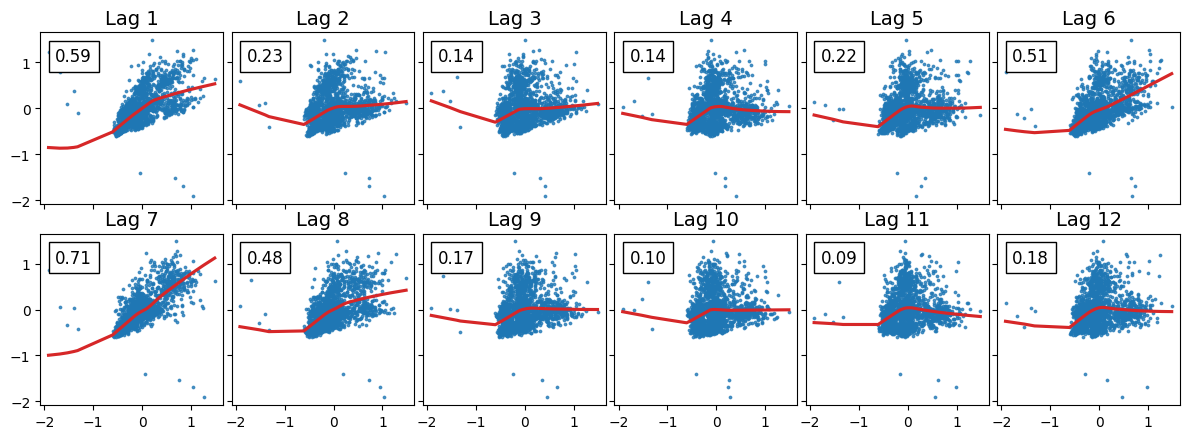

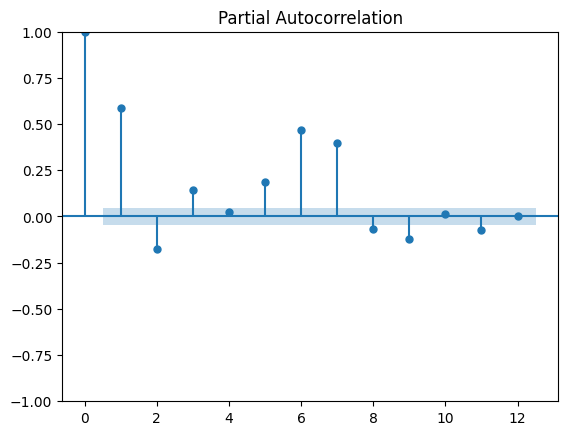

In [21]:
# --- your y and (optionally) y_trend from the Ridge baseline ---
# y: DataFrame index=Period[D], cols MultiIndex (store_nbr, family)
# y_trend: same shape as y (trend+seasonality baseline)
# If you don't have y_trend yet, set y_resid = y.copy()

# residuals to isolate cycles (recommended)
y_resid = (y - y_trend).copy()  # remove trend/seasonality
y_resid = y_resid.replace([np.inf, -np.inf], np.nan).dropna(how="all", axis=0)


def zscore_cols(df: pd.DataFrame) -> pd.DataFrame:
    mu = df.mean(axis=0)
    sig = df.std(axis=0, ddof=0).replace(0, np.nan)
    return (df - mu) / sig


# Global standardized mean (all series)
global_cycle = zscore_cols(y_resid).mean(axis=1).dropna()
# Lag plots & PACF on the global cycle:
_ = plot_lags(global_cycle, lags=12, nrows=2)
_ = plot_pacf(global_cycle, lags=12)

In [22]:
oil = pd.read_csv(
        f"{BASE_DIR}/oil.csv",
        usecols=["date", "dcoilwtico"],
        dtype={"dcoilwtico": "float32"},
        parse_dates=["date"],
        infer_datetime_format=True,
    )
oil["date"] = oil.date.dt.to_period("D")
oil = oil.set_index("date").sort_index()
# Put on daily grid and forward-fill only (no backfill, no median fill)
oil = oil.asfreq("D")
oil["dcoilwtico"] = oil["dcoilwtico"].ffill()
oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997


In [23]:
transactions = pd.read_csv(
    f"{BASE_DIR}/transactions.csv",
    usecols=["store_nbr", "transactions", "date"],
    dtype={
        "store_nbr": "category",
        "transactions": "uint32",
    },
    parse_dates=["date"],
    infer_datetime_format=True,
)
transactions["date"] = transactions.date.dt.to_period("D")
transactions = transactions.set_index(["date", "store_nbr"]).sort_index()
transactions.head()

transactions
date       store_nbr              
2013-01-01 25                  770
2013-01-02 1                  2111
           10                 1293
           11                 3547
           12                 1362

## Prep residuals (global and by store)

In [24]:
def ensure_daily_timestamp_index(s: pd.Series) -> pd.Series:
    s = s.copy()
    idx = s.index
    if isinstance(idx, pd.PeriodIndex):
        s.index = idx.to_timestamp()
    else:
        s.index = pd.to_datetime(idx)
    return s.asfreq("D")


def zscore_cols(df: pd.DataFrame) -> pd.DataFrame:
    mu = df.mean(axis=0)
    sd = df.std(axis=0, ddof=0).replace(0, np.nan)
    return (df - mu) / sd


# y: wide (date Period[D] x (store_nbr,family)); y_trend same shape
y_resid = y - y_trend
global_resid = zscore_cols(y_resid).mean(axis=1).dropna()
glob = ensure_daily_timestamp_index(global_resid)
store_resid = y_resid.groupby(level="store_nbr", axis=1).sum()

## CCF: Oil vs Global Sales Residual

Returns → positive at ~80 weeks: a shock in oil ~1.5 years ago lines up with higher residual sales today.

Levels → negative to ~80 then positive: levels co-trend with the deterministic terms; the sign flip at long lags is common when trend absorption differs between the two series. That’s why the returns features are often cleaner.

<Figure size 900x320 with 0 Axes>

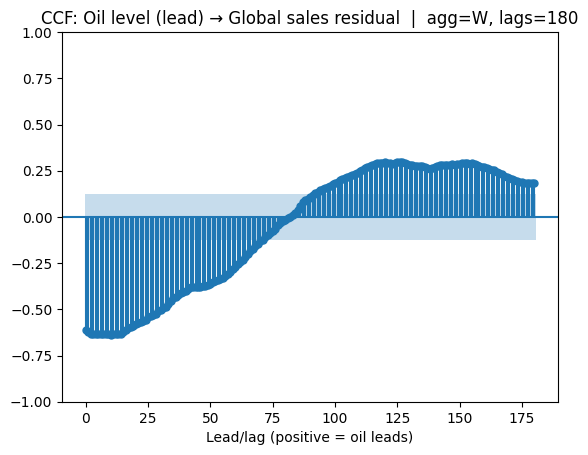

In [25]:
def plot_ccf_oil_global_long(oil_df: pd.DataFrame,
                             glob_resid: pd.Series,
                             lags: int = 180,
                             agg: str = "W",
                             use_returns: bool = True,
                             title: Optional[str] = None):
    """
    Oil vs global deseasoned sales:
      - aggregates to weekly by default,
      - looks out to 26 weeks (lags=180 days),
      - no backfill, no median-filling.
    """
    # 1) daily aligned series
    oil_s = ensure_daily_timestamp_index(oil_df["dcoilwtico"].astype(float)).ffill()
    glob_s = ensure_daily_timestamp_index(glob_resid).ffill()

    # 2) transform: returns or levels
    if use_returns:
        oil_x = np.log(oil_s.replace(0.0, np.nan)).ffill().diff()
        # glob residuals are already high-frequency; keep as-is
        y_lab = "Global sales residual"
        x_lab = "Oil log-returns"
    else:
        oil_x = oil_s  # continuous level
        y_lab = "Global sales residual"
        x_lab = "Oil level"

    # 3) optional weekly/monthly aggregation to capture macro timing
    if agg is not None:
        oil_x = oil_x.resample(agg).mean()
        glob_s = glob_s.resample(agg).median()

    df = pd.concat({"glob": glob_s, "oil_x": oil_x}, axis=1).dropna()
    if df.empty:
        print("[warn] No overlap after alignment.")
        return None

    plt.figure(figsize=(9, 3.2))
    plot_ccf(df["oil_x"], df["glob"], lags=lags)
    plt.title(title or f"CCF: {x_lab} (lead) → {y_lab}  |  agg={agg}, lags={lags}")
    plt.xlabel("Lead/lag (positive = oil leads)")
    plt.show()

# Call with longer window (26 weeks) and weekly aggregation
plot_ccf_oil_global_long(oil, glob, lags=180, agg="W", use_returns=False)

## CCF: Transactions vs Store Sales Residual

CCF is most informative per store. We’ll (a) inspect a single store, and (b) optionally summarize peak lags across all stores.

### Summarize peak CCF lags across all stores (quick grid search)

This gives, for each store, the lag in [-12, +12] with the highest absolute correlation.

[ok] Overlap: 2017-04-21 → 2017-08-15, N=117
[ok] Overlap: 2015-08-22 → 2017-08-15, N=725
[ok] Overlap: 2013-01-03 → 2017-08-15, N=1686
[ok] Overlap: 2013-01-03 → 2017-08-15, N=1686
[ok] Overlap: 2013-01-03 → 2017-08-15, N=1686
[ok] Overlap: 2013-01-03 → 2017-08-15, N=1686


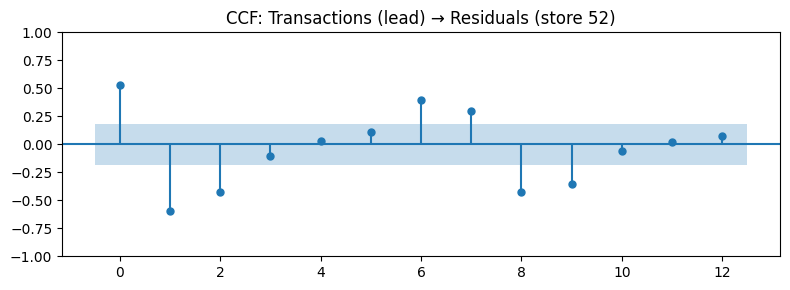

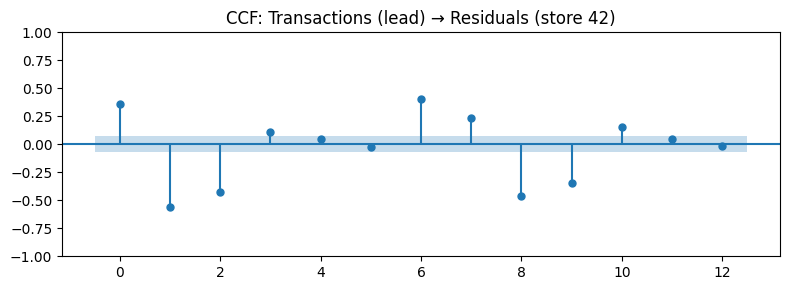

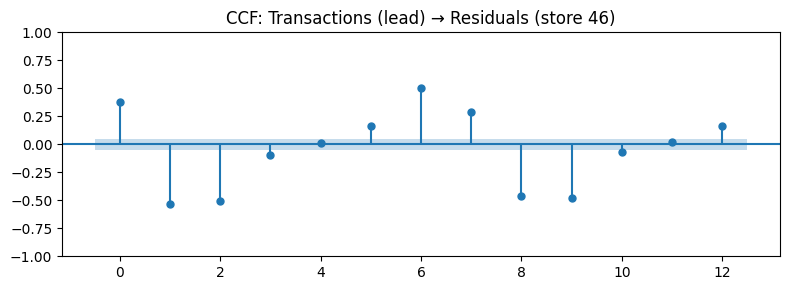

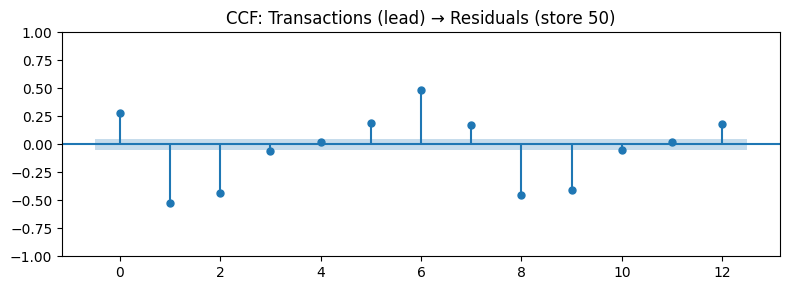

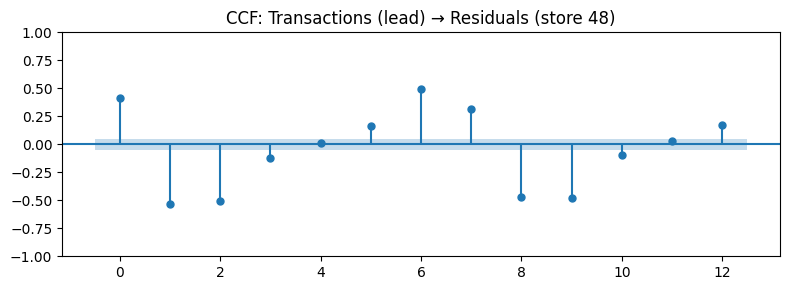

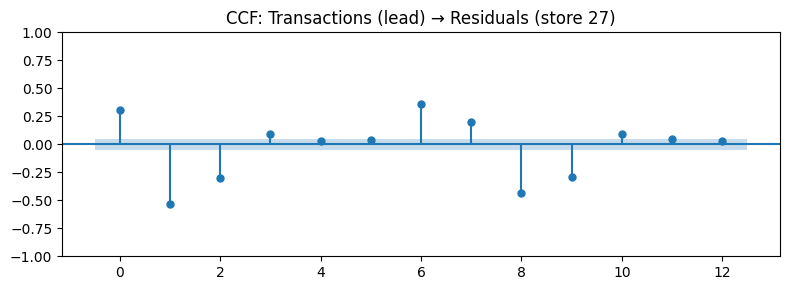

In [26]:
# ---------- 3) All-stores summary of best lag ----------
def summarize_transactions_ccf_allstores(transactions, lags=12):
    tx = transactions.copy()
    if isinstance(tx.index, pd.MultiIndex):
        if tx.index.names[0] != "store_nbr":
            tx = tx.reorder_levels(["store_nbr", "date"]).sort_index()

    rows = []
    for s in store_resid.columns:
        res = ensure_daily_timestamp_index(store_resid[s]).ffill()
        try:
            tx_s = tx.xs(s, level="store_nbr")["transactions"]
        except KeyError:
            continue
        tx_s = ensure_daily_timestamp_index(tx_s).ffill()
        tx_ret = np.log1p(tx_s).diff()
        df = pd.concat({"res": res, "tx_ret": tx_ret}, axis=1).dropna()
        if df.empty:
            continue

        best = None
        for k in range(-lags, lags + 1):
            c = df["res"].corr(df["tx_ret"].shift(k))
            if np.isfinite(c):
                if best is None or abs(c) > abs(best[1]):
                    best = (k, c)
        if best:
            n = len(df.dropna())
            ci = 1.96 / np.sqrt(n) if n > 0 else np.nan  # approx 95% threshold
            rows.append(
                {
                    "store_nbr": s,
                    "best_lag": best[0],
                    "corr": best[1],
                    "n": n,
                    "ci95": ci,
                }
            )
    out = pd.DataFrame(rows).sort_values("corr", key=np.abs, ascending=False)
    return out


def _match_key_in_index_like(key, candidates):
    m = {str(c): c for c in candidates}
    if str(key) not in m:
        raise KeyError(
            f"{key!r} not found. Available (first 10): {list(m.keys())[:10]}"
        )
    return m[str(key)]


def plot_ccf_transactions_store(transactions, store_id, lags=12, min_points=40):
    # 1) residuals for this store
    store_label = _match_key_in_index_like(store_id, store_resid.columns)
    s_res = ensure_daily_timestamp_index(store_resid[store_label]).ffill()

    # 2) transactions for this store
    tx = transactions.copy()
    if isinstance(tx.index, pd.MultiIndex):
        if tx.index.names[0] != "store_nbr":
            tx = tx.reorder_levels(["store_nbr", "date"]).sort_index()
        tx_label = _match_key_in_index_like(
            store_id, tx.index.get_level_values("store_nbr").unique()
        )
        tx_s = tx.xs(tx_label, level="store_nbr")["transactions"]
    else:
        tx_s = tx["transactions"]
    tx_s = ensure_daily_timestamp_index(tx_s).ffill()

    # 3) transforms
    tx_ret = np.log1p(tx_s).diff()
    df = pd.concat({"res": s_res, "tx_ret": tx_ret}, axis=1).dropna()

    # 4) guardrails and info
    if df.empty or len(df) < max(min_points, lags + 5):
        print(
            f"[warn] Not enough overlap to plot CCF for store {store_id} "
            f"(len={len(df)}, lags={lags}). Try a different store or lower lags."
        )
    else:
        print(
            f"[ok] Overlap: {df.index.min().date()} → {df.index.max().date()}, N={len(df)}"
        )

    # 5) explicit fig/ax; return fig so Jupyter renders it
    fig, ax = plt.subplots(figsize=(8, 3))
    plot_ccf(df["tx_ret"], df["res"], lags=lags, ax=ax)
    ax.set_title(f"CCF: Transactions (lead) → Residuals (store {store_id})")
    fig.tight_layout()
    return fig


ccf_summary = summarize_transactions_ccf_allstores(transactions, lags=12)

# Take 6 representative stores (highest |corr|) and plot CCF bars
top6 = (
    ccf_summary.reindex(ccf_summary["corr"].abs().sort_values(ascending=False).index)
    .head(6)["store_nbr"]
    .tolist()
)

for s in top6:
    _ = plot_ccf_transactions_store(
        transactions, store_id=s, lags=12
    )  # uses the robust function we wrote

# OnPromotion vs residual cycles

Treat `onpromotion` as KNOWN in the future (lead indicator). Promos are multi-day, so raw and even mildly prewhitened CCFs smear across many leads. The event-study below shows clear local bumps at +2 and a strong peak near +10. That’s a big hint for distributed-lag / exposure style features.

,store_nbr,family,best_lead,corr,n,ci95,ar_order
1404,52,GROCERY I,0,0.944020,1688,0.047706,0
1416,52,PERSONAL CARE,0,0.927653,1688,0.047706,0
1400,52,DAIRY,0,0.927511,1688,0.047706,0
1396,52,BEVERAGES,0,0.926103,1688,0.047706,0
1410,52,HOME CARE,0,0.909959,1688,0.047706,0
1399,52,CLEANING,0,0.907080,1688,0.047706,0
429,22,LAWN AND GARDEN,0,0.905475,1688,0.047706,0
1414,52,"LIQUOR,WINE,BEER",0,0.889532,1688,0.047706,0
793,33,SCHOOL AND OFFICE SUPPLIES,0,0.853094,1688,0.047706,0
1031,40,SCHOOL AND OFFICE SUPPLIES,0,0.849105,1688,0.047706,0


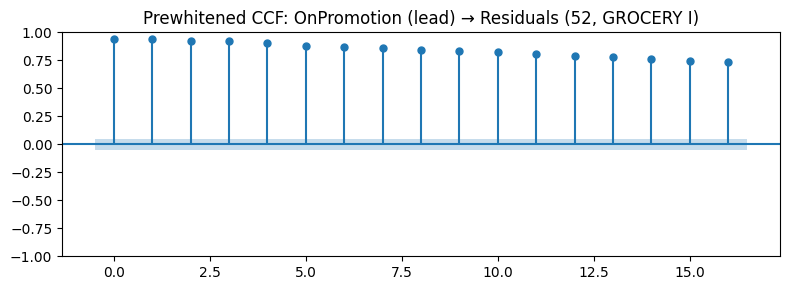

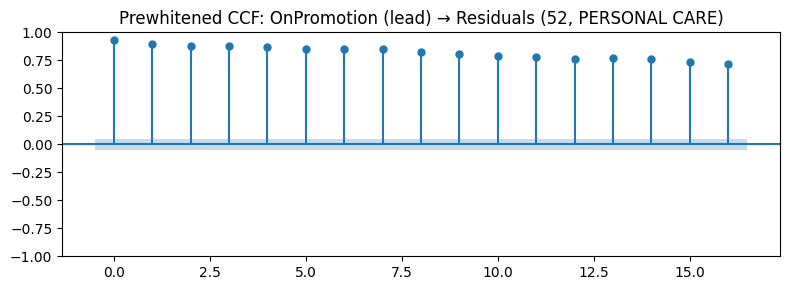

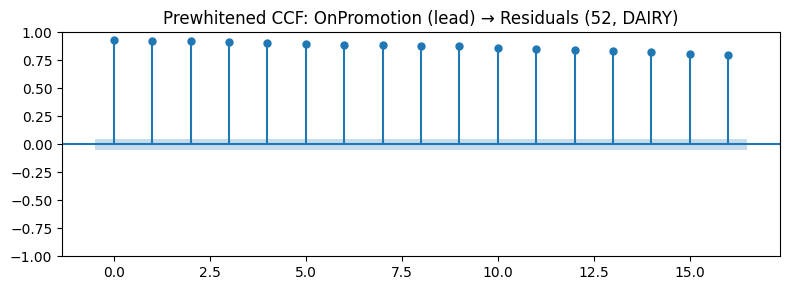

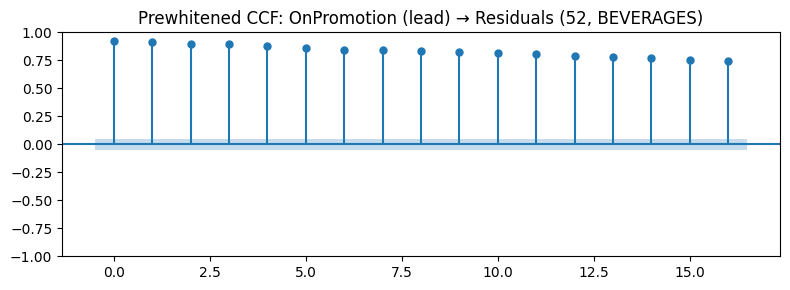

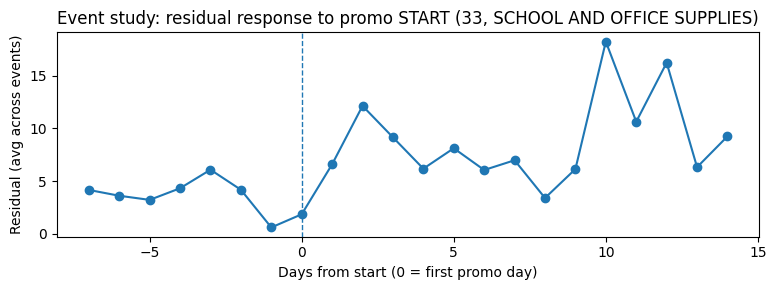

In [ ]:
# 0) Same-grain matrices (date x (store,family))
onpromo_wide = (
    store_sales["onpromotion"]
    .unstack(["store_nbr", "family"])
    .sort_index()
    .astype("float32")
    .fillna(0.0)
)
# Binary and change versions (useful for event study)
onpromo_bin = (onpromo_wide > 0).astype("float32")
onpromo_start = (onpromo_bin.astype("int8").diff() == 1).astype("int8")  # starts where it flips 0→1

def _ensure_daily(s: pd.Series) -> pd.Series:
    idx = s.index
    idx = idx.to_timestamp() if isinstance(idx, pd.PeriodIndex) else pd.to_datetime(idx)
    return pd.Series(s.values, index=idx, name=s.name).asfreq("D")

def _demean(s: pd.Series) -> pd.Series:
    return s - s.mean()

def _apply_ar_filter(series: pd.Series, phis: np.ndarray) -> pd.Series:
    """Apply AR(p) polynomial 1 - phi1 L - ... - phip L^p to series (demeaned)."""
    out = series.copy()
    for i, phi in enumerate(phis, start=1):
        out = out - phi * series.shift(i)
    return out

def _fit_ar_phis(x: pd.Series, max_ar: int = 7) -> np.ndarray:
    """
    Fit AR(p) (trend='n') to x and return phis for the best AIC model.
    Returns empty array if no model can be fit → no prewhitening.
    """
    x0 = x.dropna()
    best = None
    for p in range(1, max_ar + 1):
        try:
            m = AutoReg(x0, lags=p, trend='n', old_names=False).fit()
            if best is None or m.aic < best[0]:
                # params are lag coeffs only because trend='n'
                phis = m.params.values  # length p
                best = (m.aic, phis)
        except Exception:
            continue
    return np.array([]) if best is None else best[1]

def summarize_onpromo_ccf_by_pair_prewhiten(y_resid_wide: pd.DataFrame,
                                            onpromo_wide: pd.DataFrame,
                                            max_lead: int = 16,
                                            max_ar: int = 7,
                                            min_points: int = 100) -> pd.DataFrame:
    """
    For each (store,family), prewhiten onpromotion with AR(p), filter residuals with same polynomial,
    then compute best positive lead k in [0..max_lead] maximizing |corr|.
    """
    common = y_resid_wide.columns.intersection(onpromo_wide.columns)
    rows = []
    for col in common:
        res = _ensure_daily(y_resid_wide[col]).ffill()
        onp = _ensure_daily(onpromo_wide[col]).ffill()

        # Demean both; fit AR on onpromotion only
        onp0 = _demean(onp)
        res0 = _demean(res)
        phis = _fit_ar_phis(onp0, max_ar=max_ar)

        # If we have AR structure, remove it from both series
        x_pw = _apply_ar_filter(onp0, phis) if len(phis) else onp0
        y_pw = _apply_ar_filter(res0, phis) if len(phis) else res0

        df = pd.concat({"res": y_pw, "onp": x_pw}, axis=1).dropna()
        if len(df) < max(min_points, max_lead + 5):
            continue

        best = None
        for k in range(0, max_lead + 1):  # promotions lead
            c = df["res"].corr(df["onp"].shift(k))
            if np.isfinite(c) and (best is None or abs(c) > abs(best[1])):
                best = (k, c)
        if best is None:
            continue

        store_nbr, family = col
        n = len(df)
        rows.append({
            "store_nbr": store_nbr,
            "family": family,
            "best_lead": int(best[0]),
            "corr": float(best[1]),
            "n": int(n),
            "ci95": float(1.96 / np.sqrt(n)) if n > 0 else np.nan,
            "ar_order": int(len(phis))
        })
    out = pd.DataFrame(rows).sort_values("corr", key=np.abs, ascending=False)
    return out

def plot_ccf_onpromotion_pair_prewhiten(onpromo_wide: pd.DataFrame,
                                        y_resid_wide: pd.DataFrame,
                                        store_id,
                                        family,
                                        lags: int = 16,
                                        max_ar: int = 7):
    """CCF bar plot after prewhitening (positive bars ⇒ onpromotion leads by k days)."""
    col_key = (
        match_key_in_index_like(store_id, y_resid_wide.columns.get_level_values("store_nbr")),
        match_key_in_index_like(family,    y_resid_wide.columns.get_level_values("family")),
    )
    res = _ensure_daily(y_resid_wide[col_key]).ffill()
    onp = _ensure_daily(onpromo_wide[col_key]).ffill()

    onp0 = _demean(onp)
    res0 = _demean(res)
    phis = _fit_ar_phis(onp0, max_ar=max_ar)
    x_pw = _apply_ar_filter(onp0, phis) if len(phis) else onp0
    y_pw = _apply_ar_filter(res0, phis) if len(phis) else res0

    df = pd.concat({"res": y_pw, "onp": x_pw}, axis=1).dropna()
    if len(df) < lags + 5:
        print(f"[warn] Not enough overlap for store {store_id}, family {family} (len={len(df)}).")
        return None

    fig, ax = plt.subplots(figsize=(8, 3))
    plot_ccf(df["onp"], df["res"], lags=lags, ax=ax)
    ax.set_title(f"Prewhitened CCF: OnPromotion (lead) → Residuals ({store_id}, {family})")
    fig.tight_layout()
    return fig

# --- Run the prewhitened summary (0..16 day leads)
onp_ccf_pw = summarize_onpromo_ccf_by_pair_prewhiten(y_resid, onpromo_wide, max_lead=16, max_ar=7)
display(onp_ccf_pw.head(10))

# --- Plot top pairs to verify the peak is local (not a long decay)
for s, f in onp_ccf_pw.head(4)[["store_nbr", "family"]].itertuples(index=False, name=None):
    _ = plot_ccf_onpromotion_pair_prewhiten(onpromo_wide, y_resid, s, f, lags=16, max_ar=7)

# === Event-study: average residual response around promotion STARTS ===========
def event_study_onpromotion_starts(y_resid_wide: pd.DataFrame,
                                   onpromo_bin_wide: pd.DataFrame,
                                   store_id,
                                   family,
                                   pre_days: int = 7,
                                   post_days: int = 14,
                                   min_gap: int = 7):
    """
    Aligns on days where promotion flips 0→1 and averages residuals over a window [-pre, +post].
    min_gap enforces separation between starts so windows don't overlap heavily.
    """
    # pick the (store, family) column
    try:
        s_key = match_key_in_index_like(store_id, y_resid_wide.columns.get_level_values("store_nbr"))
    except NameError:
        # fallback if helper is named with underscore in your notebook
        s_key = _match_key_in_index_like(store_id, y_resid_wide.columns.get_level_values("store_nbr"))
    try:
        f_key = match_key_in_index_like(family, y_resid_wide.columns.get_level_values("family"))
    except NameError:
        f_key = _match_key_in_index_like(family, y_resid_wide.columns.get_level_values("family"))
    col = (s_key, f_key)

    # daily, forward-filled residuals and binary promotion
    res = _ensure_daily(y_resid_wide[col]).ffill()
    onp_b = _ensure_daily(onpromo_bin_wide[col]).ffill()

    # find starts (0 -> 1)
    starts_mask = (onp_b.astype("int8").diff() == 1).fillna(False)
    start_dates = starts_mask.index[starts_mask]

    if len(start_dates) == 0:
        print(f"[info] No starts for ({store_id}, {family}).")
        return None

    # enforce minimum spacing between starts without using Timestamp.min
    valid_starts = []
    last_dt = None
    gap = pd.Timedelta(min_gap, "D")
    for dt in start_dates:
        if (last_dt is None) or ((dt - last_dt) >= gap):
            valid_starts.append(dt)
            last_dt = dt

    if not valid_starts:
        print(f"[info] No starts after min_gap for ({store_id}, {family}).")
        return None

    # build matrix of residuals around each start
    win = range(-pre_days, post_days + 1)
    mat = []
    for dt in valid_starts:
        # target index for this window
        idx = pd.date_range(dt - pd.Timedelta(pre_days, "D"),
                            dt + pd.Timedelta(post_days, "D"), freq="D")
        seg = res.reindex(idx)
        if seg.isna().any():
            # skip partial windows
            continue
        mat.append(seg.values)

    if not mat:
        print(f"[info] Not enough full windows for ({store_id}, {family}).")
        return None

    M = np.vstack(mat)
    avg = M.mean(axis=0)

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    x = np.arange(-pre_days, post_days + 1)
    ax.plot(x, avg, marker="o")
    ax.axvline(0, linestyle="--", linewidth=1)
    ax.set_title(f"Event study: residual response to promo START ({store_id}, {family})")
    ax.set_xlabel("Days from start (0 = first promo day)")
    ax.set_ylabel("Residual (avg across events)")
    fig.tight_layout()
    return fig

# Example event-study on a strong pair (fall back to any pair with starts)
ex = None
for s, f in onp_ccf_pw[["store_nbr", "family"]].itertuples(index=False, name=None):
    if onpromo_start[(s, f)].sum() > 3:
        ex = (s, f)
        break
if ex:
    _ = event_study_onpromotion_starts(y_resid, onpromo_bin, ex[0], ex[1], pre_days=7, post_days=14, min_gap=7)

## Create Lags

I only saw cross-correlation for transactions. Oil appeared to not have any cross-correlation, so we can exclude that dataset. The cross-correlation for transactions and autocorrelation gave us a effects up to a lag of 9 for each. So I will set those here.

In [28]:
def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)

### Add 9 lags of sales (per store and per family)

In [29]:
y_lag = make_lags(y, lags=9)
y_lag.columns = y_lag.columns.to_flat_index() # Flatten the columns from 3 levels to 1
y_lag.head()

,"(y_lag_1, 1, AUTOMOTIVE)","(y_lag_1, 1, BABY CARE)","(y_lag_1, 1, BEAUTY)","(y_lag_1, 1, BEVERAGES)","(y_lag_1, 1, BOOKS)","(y_lag_1, 1, BREAD/BAKERY)","(y_lag_1, 1, CELEBRATION)","(y_lag_1, 1, CLEANING)","(y_lag_1, 1, DAIRY)","(y_lag_1, 1, DELI)",...,"(y_lag_9, 9, MAGAZINES)","(y_lag_9, 9, MEATS)","(y_lag_9, 9, PERSONAL CARE)","(y_lag_9, 9, PET SUPPLIES)","(y_lag_9, 9, PLAYERS AND ELECTRONICS)","(y_lag_9, 9, POULTRY)","(y_lag_9, 9, PREPARED FOODS)","(y_lag_9, 9, PRODUCE)","(y_lag_9, 9, SCHOOL AND OFFICE SUPPLIES)","(y_lag_9, 9, SEAFOOD)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,2.0,0.0,2.0,1091.0,0.0,470.652008,0.0,1060.0,579.0,164.069000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,3.0,0.0,0.0,919.0,0.0,310.654999,0.0,836.0,453.0,151.582001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,3.0,0.0,3.0,953.0,0.0,198.365997,0.0,827.0,460.0,131.410995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
X = X.join(y_lag, how="left")

### Add 9 lags of transactions (per store)

In [31]:
transactions = transactions.unstack()

# Columns are a MultiIndex like ('transactions', store_nbr), select that slice:
tx = transactions.xs('transactions', axis=1, level=0)

def fill_one_store(col: pd.Series, dow: pd.Index) -> pd.Series:
    # If the store has no data at all, use zeros
    if not col.notna().any():
        return col.fillna(0.0)

    # Detect the "open" window: from first non-null to last non-null
    first_to_end = col.notna().cummax()
    last_to_start = col[::-1].notna().cummax()[::-1]
    open_mask = first_to_end & last_to_start
    filled = col.copy()
    na = filled.isna()

    # Per-day-of-week medians from observed data
    med_by_dow = col.groupby(dow).transform("median")
    
    # Internal gaps -> DOW median
    interior = open_mask & na
    filled.loc[interior] = med_by_dow.loc[interior]

    # If still NaN inside open window, use store-wide median
    still_na_inside = open_mask & filled.isna()
    if still_na_inside.any():
        filled.loc[still_na_inside] = col.median()

    # Outside open window (pre-open / post-close) -> 0
    outside = ~open_mask & filled.isna()
    if outside.any():
        filled.loc[outside] = 0.0
    return filled

dow = tx.index.dayofweek # 0=Mon, ... 6=Sun
transactions = tx.apply(lambda c: fill_one_store(c, dow=dow), axis=0).astype("float32")

#### Transactions are skewed, apply log transform

<Axes: >

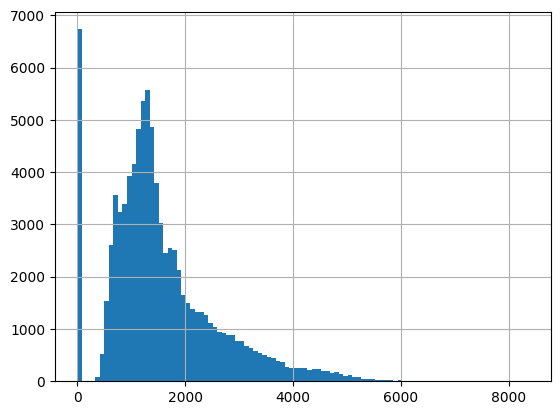

In [32]:
transactions.stack().hist(bins=100)

<Axes: >

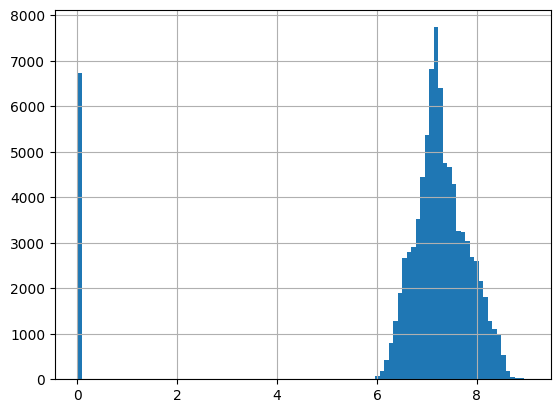

In [33]:
log_tx = np.log1p(transactions)
log_tx.stack().hist(bins=100)

In [34]:
transactions_lag = make_lags(log_tx, lags=9, name="tx").dropna()
transactions_lag.columns = transactions_lag.columns.to_flat_index() # Flatten the columsn from 2 levels to 1
transactions_lag.head()

,"(tx_lag_1, 1)","(tx_lag_1, 10)","(tx_lag_1, 11)","(tx_lag_1, 12)","(tx_lag_1, 13)","(tx_lag_1, 14)","(tx_lag_1, 15)","(tx_lag_1, 16)","(tx_lag_1, 17)","(tx_lag_1, 18)",...,"(tx_lag_9, 5)","(tx_lag_9, 50)","(tx_lag_9, 51)","(tx_lag_9, 52)","(tx_lag_9, 53)","(tx_lag_9, 54)","(tx_lag_9, 6)","(tx_lag_9, 7)","(tx_lag_9, 8)","(tx_lag_9, 9)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-10,7.555382,6.836259,7.710205,7.011214,6.723833,7.372746,7.152269,6.828712,7.013016,7.095893,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-11,7.426549,6.830874,7.729735,7.022868,6.777647,7.261225,7.183871,6.791222,7.040536,7.106606,...,7.551712,8.032035,7.593878,0.0,0.0,6.906755,7.670429,7.536364,8.086718,7.986505
2013-01-12,7.503290,6.777647,7.627544,6.978214,6.716595,7.253470,7.063904,6.816736,6.894670,7.108244,...,7.462215,7.744137,7.405496,0.0,0.0,6.825460,7.493317,7.358194,7.974189,7.781973
2013-01-13,7.295735,7.021976,7.864804,7.124478,7.073270,7.570443,7.242083,6.952729,7.234177,7.104965,...,7.404279,7.900637,7.488294,0.0,0.0,6.678342,7.426549,7.322510,7.993958,7.588830
2013-01-14,6.297109,6.921658,7.964156,7.062191,6.755769,7.183871,7.023759,7.139660,7.273787,7.227663,...,7.404888,8.149024,7.634820,0.0,0.0,6.856462,7.675546,7.377759,8.026497,7.865188


In [35]:
X = X.join(transactions_lag, how='left')

## OnPromotion leads & exposure windows

The below `onpromo` blocks turned out the be large and highly-collinear. This resulted in validation RMSLE increasing. I'll let the residdual model learn the promo effect.

In [36]:
# # === OnPromotion features at (store, family) =================================
# # Source matrix: date x (store_nbr, family)
# onp_wide = (
#     store_sales["onpromotion"]
#     .unstack(["store_nbr", "family"])
#     .sort_index()
#     .astype("float32")
#     .fillna(0.0)
# )

# # Binary “on promo” indicator (for exposure windows)
# onp_bin = (onp_wide > 0).astype("float32")

# # ---- Targeted LEADS (based on event study peaks): 0..3 and 8..10 ------------
# _leads_keep = [0, 1, 2, 3, 8, 9, 10]
# onp_leads_sel = pd.concat(
#     {f"onp_lead_{k}": onp_wide.shift(-k) for k in _leads_keep},
#     axis=1
# )

# # ---- Forward EXPOSURE windows (capture sustained uplift during promo) -------
# # Helper: sum of future indicators over a [start, end] forward window
# def _sum_lead_window(df: pd.DataFrame, start: int, end: int) -> pd.DataFrame:
#     acc = None
#     for k in range(start, end + 1):
#         part = df.shift(-k)
#         acc = part if acc is None else acc.add(part, fill_value=0.0)
#     return acc

# # Short/medium/long windows guided by your event-study:
# expo_specs = {
#     "onp_expo_0_2": (0, 2),    # immediate effect (incl. +2 local max)
#     "onp_expo_3_7": (3, 7),    # mid window
#     "onp_expo_8_14": (8, 14),  # delayed effect (around +10 peak)
# }
# onp_expo = pd.concat(
#     {name: _sum_lead_window(onp_bin, a, b) for name, (a, b) in expo_specs.items()},
#     axis=1
# )

# # ---- “start” flags (0→1 flips) with short forward reach ----------
# onp_start = (onp_bin.astype("int8").diff() == 1).astype("float32")
# start_leads = pd.concat(
#     {f"onp_start_lead_{k}": onp_start.shift(-k) for k in [0, 1, 2]},
#     axis=1
# )

# # ---- Assemble features, flatten columns, join to design matrix --------------
# onp_feats_wide = pd.concat([onp_leads_sel, onp_expo, start_leads], axis=1)

# # Keep index as Period[D] to match X; ensure consistent dtype and names
# onp_feats_wide = onp_feats_wide.astype("float32")
# onp_feats_wide.columns = onp_feats_wide.columns.to_flat_index()  # flatten MultiIndex

# # Join into your cycles matrix (this is the same pattern you used for y_lag/tx_lag)
# X = X.join(onp_feats_wide, how="left").fillna(0.0)

## Add long term oil lag features

In [37]:
# === Weekly oil features (long-lag macro) ====================================
def make_oil_weekly_features(
    oil_df: pd.DataFrame,
    daily_index: pd.DatetimeIndex,
    lag_weeks=(78, 80, 84),
    include_levels=True,
    include_returns=True,
    resample_rule="W-SUN",
    prefix="oil"
) -> pd.DataFrame:
    """
    Build weekly oil features at long lags, then upsample to daily by ffill
    (so no look-ahead within the week). Returns a DataFrame indexed by `daily_index`.
    """
    # daily aligned price, forward-fill only
    oil_d = ensure_daily_timestamp_index(oil_df["dcoilwtico"].astype("float32")).ffill()

    # weekly means labeled at week end; will be carried forward to next week safely
    oil_w = oil_d.resample(resample_rule, label="right", closed="right").mean()

    feats = {}

    if include_returns:
        # log-returns at weekly freq
        oil_lr_w = np.log(oil_w.replace(0.0, np.nan)).ffill().diff()
        for k in lag_weeks:
            s = oil_lr_w.shift(k)  # oil leads by k weeks -> use lagged returns
            feats[f"{prefix}_lr_wlag_{k}"] = s.reindex(daily_index, method="ffill")

    if include_levels:
        for k in lag_weeks:
            s = oil_w.shift(k)     # weekly level lagged by k weeks
            feats[f"{prefix}_lvl_wlag_{k}"] = s.reindex(daily_index, method="ffill")

    out = pd.DataFrame(feats, index=daily_index).astype("float32")
    return out


# --- Oil long-lag features (date-indexed, shared across all series) ----------
# Build on the notebook's daily timeline (timestamps), then convert back to Period[D]
daily_idx = y.index.to_timestamp()
oil_feats_daily = make_oil_weekly_features(oil, daily_idx, lag_weeks=(78, 80, 84),
                                           include_levels=True, include_returns=True)

# Convert to Period[D] so it joins cleanly to X
oil_feats = oil_feats_daily.copy()
oil_feats.index = oil_feats.index.to_period("D")

# Join (small set, so fine for Ridge); fill only after join to avoid alignment holes
X = X.join(oil_feats, how="left").fillna(0.0)

### Deal with `NaN`s

Fill with median.

In [38]:
# X = X.fillna(X.median())

### Convert column names to strings to handle error with tuples in feature names


In [39]:
X.columns = X.columns.astype(str)

[I 2025-08-29 00:12:36,723] A new study created in memory with name: no-name-ff2b057e-3143-4dfa-a565-37f6f82c3f71
[I 2025-08-29 00:12:43,951] Trial 0 finished with value: 0.7640525774652507 and parameters: {'alpha': 56115.16415334505}. Best is trial 0 with value: 0.7640525774652507.
[I 2025-08-29 00:12:51,183] Trial 1 finished with value: 0.7664725282667787 and parameters: {'alpha': 796945.4818643926}. Best is trial 0 with value: 0.7640525774652507.
[I 2025-08-29 00:12:58,311] Trial 2 finished with value: 0.7606410678894384 and parameters: {'alpha': 291063.59131330677}. Best is trial 2 with value: 0.7606410678894384.
[I 2025-08-29 00:13:05,432] Trial 3 finished with value: 0.7584606812199898 and parameters: {'alpha': 157513.2049977971}. Best is trial 3 with value: 0.7584606812199898.
[I 2025-08-29 00:13:12,572] Trial 4 finished with value: 0.7802999178021155 and parameters: {'alpha': 20513.38263087451}. Best is trial 3 with value: 0.7584606812199898.
[I 2025-08-29 00:13:19,735] Trial 5

[Early stop] No improvement in 12 consecutive trials. Best RMSLE so far: 0.758364
Best params: {'alpha': 144957.1649157559}
Best RMSLE: 0.7583640085970339
Best RMSE : 139.32475620312454


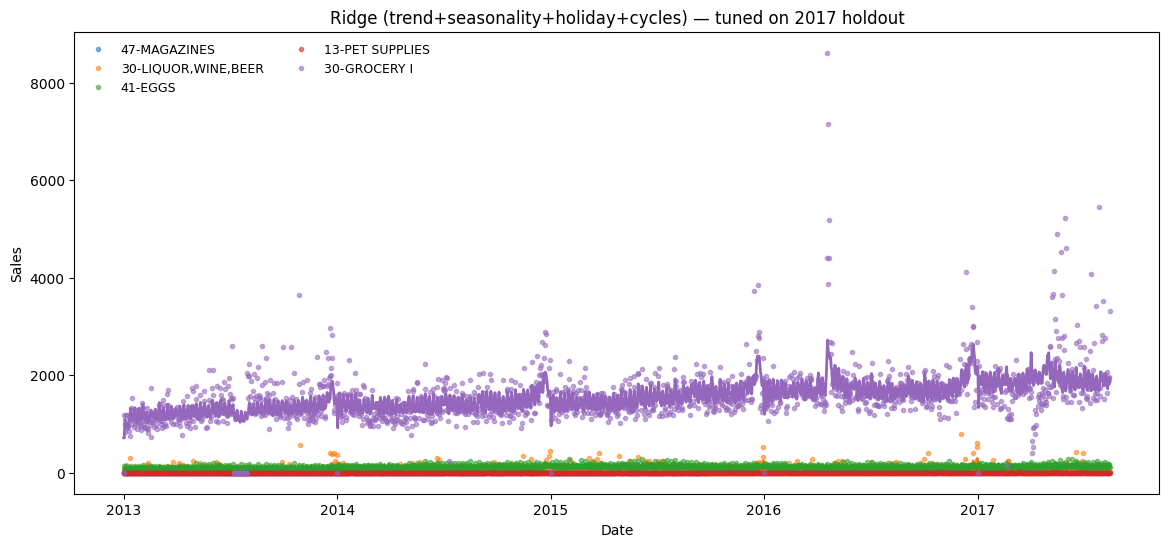

In [40]:
ridge_full, study_full = fit_ridge_with_optuna(
    X.loc[idx_train], y.loc[idx_train],
    X.loc[idx_valid], y.loc[idx_valid],
    alpha_lo=1e4, alpha_hi=1e6, patience=12
)
y_pred_1 = pd.DataFrame(ridge_full.predict(X), index=y.index, columns=y.columns)

print("Best params:", study_full.best_params)
print("Best RMSLE:", study_full.best_value)
print("Best RMSE :", study_full.best_trial.user_attrs["rmse"])

# Freeze the TRAIN feature spaces - baseline RIDGE
BASELINE_COLS = X.columns.astype(str).tolist()      # preserve order
BASELINE_DTYPES = {c: 'float32' for c in BASELINE_COLS}

# Plot a sample:
rng = np.random.default_rng(SEED)
cols = y.columns.to_list()
sel = [cols[i] for i in rng.choice(len(cols), size=5, replace=False)]

t_index = y.index.to_timestamp()
fig, ax = plt.subplots(figsize=(14, 6))
for store, fam in sel:
    series = y[(store, fam)]
    line = y_pred_1[(store, fam)]
    (pts,) = ax.plot(t_index, series.values, ".", alpha=0.55, label=f"{store}-{fam}")
    ax.plot(line.index.to_timestamp(), line.values, linewidth=2, color=pts.get_color())
ax.set_title("Ridge (trend+seasonality+holiday+cycles) — tuned on 2017 holdout")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(ncol=2, frameon=False, fontsize=9)
plt.show()

## Train on Lag Features

This is our final training before sending it over to model 2, XGBoost.

### Train/valid split masks

##  Train XGBoost on Residuals for Hybrid Model

### Get Residuals

In [41]:
resid_df = (
    (y - y_pred_1)
    .stack(['store_nbr','family'])
    .rename('Residuals')
    .to_frame()
)
resid_df.head()

Residuals
date       store_nbr family                
2013-01-01 1         AUTOMOTIVE   -1.678937
                     BABY CARE     0.000000
                     BEAUTY       -1.499990
                     BEVERAGES  -692.932577
                     BOOKS         0.076396

### Get Target

In [42]:
y2 =resid_df['Residuals']
y2.head()

date        store_nbr  family    
2013-01-01  1          AUTOMOTIVE     -1.678937
                       BABY CARE       0.000000
                       BEAUTY         -1.499990
                       BEVERAGES    -692.932577
                       BOOKS           0.076396
Name: Residuals, dtype: float64

### Get Features (X2)

In [43]:
X2 = resid_df.drop(columns=['Residuals'])
X2.head()

Empty DataFrame
Columns: []
Index: [(2013-01-01, 1, AUTOMOTIVE), (2013-01-01, 1, BABY CARE), (2013-01-01, 1, BEAUTY), (2013-01-01, 1, BEVERAGES), (2013-01-01, 1, BOOKS)]

#### Add Store Type and Cluster

In [44]:
X2 = X2.join(stores, on='store_nbr', how='left')
X2.head()

city      state type cluster
date       store_nbr family                                   
2013-01-01 1         AUTOMOTIVE  Quito  Pichincha    D      13
                     BABY CARE   Quito  Pichincha    D      13
                     BEAUTY      Quito  Pichincha    D      13
                     BEVERAGES   Quito  Pichincha    D      13
                     BOOKS       Quito  Pichincha    D      13

#### Add Local & Regional Holidays

In [45]:
# --- Local & Regional (deduped for merges) ---
def build_local_table(holidays_df):
    df = (
        holidays_df.loc[holidays_df["description"] == "Local", ["locale_name", "additional", "additional_squared"]]
        .rename(columns={"locale_name": "city"})
        .reset_index()
    )
    # Prefer the closest offset (min |additional|) if duplicates on (date, city)
    df["abs_add"] = df["additional"].abs()
    df = (
        df.sort_values(["date", "city", "abs_add"])
        .drop_duplicates(["date", "city"], keep="first")
        .drop(columns="abs_add")
        .set_index("date")
    )
    df["local_holiday"] = 1.0
    return df

def build_regional_table(holidays_df):
    df = (
        holidays_df.loc[holidays_df["description"] == "Regional", ["locale_name"]]
        .rename(columns={"locale_name": "state"})
        .reset_index()
    )
    df = df.drop_duplicates(["date", "state"]).set_index("date")
    df["regional_holiday"] = 1.0
    return df

local_holidays = build_local_table(holidays)
regional_holidays = build_regional_table(holidays)

# Add local
X2 = X2.reset_index().merge(local_holidays.reset_index(), on=['date','city'], how='left', validate='many_to_one').set_index('date').drop('city', axis=1)
X2 = X2.fillna({'additional': 0.0, 'additional_squared': 0.0, 'local_holiday': 0.0})

# Add regional
X2 = X2.reset_index().merge(regional_holidays.reset_index(), on=['date','state'], how='left', validate='many_to_one').set_index('date').drop('state', axis=1)
X2 = X2.fillna({'regional_holiday': 0.0})
X2.head()

,store_nbr,family,type,cluster,additional,additional_squared,local_holiday,regional_holiday
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,D,13,0.0,0.0,0.0,0.0
2013-01-01,1,BABY CARE,D,13,0.0,0.0,0.0,0.0
2013-01-01,1,BEAUTY,D,13,0.0,0.0,0.0,0.0
2013-01-01,1,BEVERAGES,D,13,0.0,0.0,0.0,0.0
2013-01-01,1,BOOKS,D,13,0.0,0.0,0.0,0.0


#### Encode Features

In [46]:
family_one_hot = pd.get_dummies(X2['family'], drop_first=True, dtype=float)
store_nbr_one_hot = pd.get_dummies(X2['store_nbr'], prefix='store_nbr_', drop_first=True, dtype=float)
type_one_hot = pd.get_dummies(X2['type'], prefix='type_', drop_first=True, dtype=float)
cluster_one_hot = pd.get_dummies(X2['cluster'], prefix='cluster', drop_first=True, dtype=float)

# Build “global” categories from training data
FAMILY_CATS = pd.Index(y.columns.get_level_values('family').unique(), name='family')
STORE_CATS  = pd.Index(y.columns.get_level_values('store_nbr').unique(), name='store_nbr')
TYPE_CATS   = stores['type'].astype('category').cat.categories
CLUSTER_CATS = stores['cluster'].astype('category').cat.categories

X2 = pd.concat([X2, family_one_hot, store_nbr_one_hot, type_one_hot, cluster_one_hot], axis=1).drop(['type', 'cluster'], axis=1)
X2.head()

,store_nbr,family,additional,additional_squared,local_holiday,regional_holiday,BABY CARE,BEAUTY,BEVERAGES,BOOKS,...,cluster_16,cluster_17,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BABY CARE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEAUTY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BEVERAGES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1,BOOKS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Add in a compact set of `onpromotion` features

I took `onpromotion` features out of the Ridge model since it increase RMSLE. Adding them in here for the residual model, XGB.

In [47]:
# === Compact onpromotion features for residual learner =======================
# Source is per (date, store, family). Keep it tiny: 2 exposure windows + a start flag.
def create_onpromo_feat(df):
    onp_wide = (
        df["onpromotion"]
        .unstack(["store_nbr", "family"])
        .sort_index()
        .astype("float32")
        .fillna(0.0)
    )
    onp_bin = (onp_wide > 0).astype("float32")
    
    def _sum_lead_window(df: pd.DataFrame, start: int, end: int) -> pd.DataFrame:
        acc = None
        for k in range(start, end + 1):
            part = df.shift(-k)
            acc = part if acc is None else acc.add(part, fill_value=0.0)
        return acc
    
    # Two exposure windows based on your event study (+2 bump, +10 peak)
    expo_specs = {
        "onp_expo_0_2": (0, 2),
        "onp_expo_8_14": (8, 14),
    }
    onp_expo = pd.concat(
        {name: _sum_lead_window(onp_bin, a, b) for name, (a, b) in expo_specs.items()},
        axis=1
    ).astype("float32")
    
    # Start flag (0→1) at t (and optionally t+1 if you like)
    onp_start = (onp_bin.astype("int8").diff() == 1).astype("float32")
    onp_start = pd.concat({"onp_start_lead_0": onp_start.shift(0)}, axis=1)
    
    # Assemble and convert wide→long (index: date, store_nbr, family; columns: 3 features)
    onp_feats_wide = pd.concat([onp_expo, onp_start], axis=1)
    onp_long = onp_feats_wide.stack(["store_nbr", "family"])
    onp_long.columns = onp_long.columns.map(str)  # plain strings
    
    return onp_long

onp_long = create_onpromo_feat(store_sales)

# --- Merge compact promo features into X2 (cheap: +3 columns) --------------
X2 = X2.reset_index().merge(
    onp_long.reset_index(),
    on=["date", "store_nbr", "family"],
    how="left",
    validate="many_to_one").set_index(['date', 'store_nbr' ,'family'])

In [48]:
# Baseline (Ridge) predictions in long form
y1_long = (
    y_pred_1
    .stack(['store_nbr','family'])
    .rename('Baseline')
    .reorder_levels(['date','store_nbr','family'])
    .sort_index()
)

# Ground-truth in long form
y_long = (
    y
    .stack(['store_nbr','family'])
    .rename('sales')
    .reorder_levels(['date','store_nbr','family'])
    .sort_index()
)

# Residual target for the residual model
y2 = (y_long - y1_long).rename('Residuals')

# --- Guardrails: make sure indices are clean and aligned ----------------------
for name, obj in [('X2', X2), ('y2', y2), ('y1_long', y1_long), ('y_long', y_long)]:
    assert list(obj.index.names) == ['date','store_nbr','family'], f"{name} index must be (date, store_nbr, family)"
    assert obj.index.is_unique, f"{name} has duplicate index rows; fix merges/dedup first"

# Align X2 and y2 to the exact same keys (intersection) to avoid stray rows
common = X2.index.intersection(y2.index)
X2 = X2.loc[common].sort_index()
y2 = y2.loc[common].sort_index()

# --- Time split using the 'date' level ---------------------------------------
cutoff = pd.Period('2017-01-01', freq='D')
date_idx = X2.index.get_level_values('date')

idx_train = date_idx < cutoff
idx_valid = ~idx_train

X2_train, y2_train = X2[idx_train], y2[idx_train]
X2_valid, y2_valid = X2[idx_valid], y2[idx_valid]

# Baseline and truth on the *same* rows as y2_valid:
y1_valid = y1_long.loc[y2_valid.index]
y_valid  = y_long.loc[y2_valid.index]

# --- XGB on residuals ---
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    tree_method='hist',
    random_state=SEED,
)

model.fit(
    X2_train, y2_train,
    eval_set=[(X2_valid, y2_valid)],
    eval_metric='rmse',
    early_stopping_rounds=100,
    verbose=False,
)

# --- Validation metrics (corrected) ---
y2_valid_pred = pd.Series(model.predict(X2_valid), index=X2_valid.index, name='res2_valid')
y_valid_pred  = (y1_valid + y2_valid_pred).clip(lower=0)

print("Baseline RMSLE:",
      (mean_squared_log_error(y_valid.clip(lower=0), y1_valid.clip(lower=0))**0.5))
print("Hybrid   RMSLE:",
      (mean_squared_log_error(y_valid.clip(lower=0), y_valid_pred)**0.5))

# --- Retrain residual model on FULL data -------------------------------------
best_n = getattr(model, "best_iteration", None) or model.n_estimators
final_model = XGBRegressor(
    n_estimators=best_n,
    learning_rate=model.get_xgb_params()['learning_rate'],
    max_depth=model.get_xgb_params()['max_depth'],
    subsample=model.get_xgb_params()['subsample'],
    colsample_bytree=model.get_xgb_params()['colsample_bytree'],
    reg_lambda=model.get_xgb_params()['reg_lambda'],
    n_jobs=-1,
    tree_method=model.get_xgb_params().get('tree_method', 'hist'),
    random_state=SEED,
)
final_model.fit(X2, y2)
print(f"Trained final residual model with n_estimators={best_n}.")

# Residual predictions on FULL index (train+valid)
y2_full_pred = pd.Series(final_model.predict(X2), index=X2.index, name='Res2')

# --- Combine baseline + residual (indices match exactly) ----------------------
# If shapes differ, reindex; but with the guardrails above they should be identical.
y_pred_long = (y1_long.loc[y2_full_pred.index] + y2_full_pred).rename('sales').clip(lower=0)

# Freeze the TRAIN feature spaces - residual
RESIDUAL_COLS = X2.columns.astype(str).tolist()     # preserve order
RESIDUAL_DTYPES = {c: 'float32' for c in RESIDUAL_COLS}
print("\nBaseline features:", len(BASELINE_COLS))
print("Residual features:", len(RESIDUAL_COLS))

Baseline RMSLE: 0.7583640085970341
Hybrid   RMSLE: 0.7194696318981867
Trained final residual model with n_estimators=367.

Baseline features: 16582
Residual features: 112


# Submission

## Load Test Data

In [49]:
test = pd.read_csv(
    f"{BASE_DIR}/test.csv",
    dtype={
        "id": "uint32",
        "store_nbr": "category",
        "family": "category",
        "onpromotion": "uint32",
    },
parse_dates=["date"],
infer_datetime_format=True,
)
test["date"] = test.date.dt.to_period("D")
test = test.set_index(["store_nbr", "family", "date"]).sort_index()

In [50]:
(store_sales['sales'] == 0).mean()

0.3129506999261552

In [51]:
store_sales['sales'].describe(percentiles=[.5, .9, .99, .999])

count    3.000888e+06
mean     3.577757e+02
std      1.093276e+03
min      0.000000e+00
50%      1.100000e+01
90%      8.670000e+02
99%      5.507000e+03
99.9%    1.207623e+04
max      1.247170e+05
Name: sales, dtype: float64

## Predict Transactions

Transaction lag was a predicitve feature during training, but we don't have that data. We need to fit the transaction training data's trend and seasonality to project 16 data points for test.

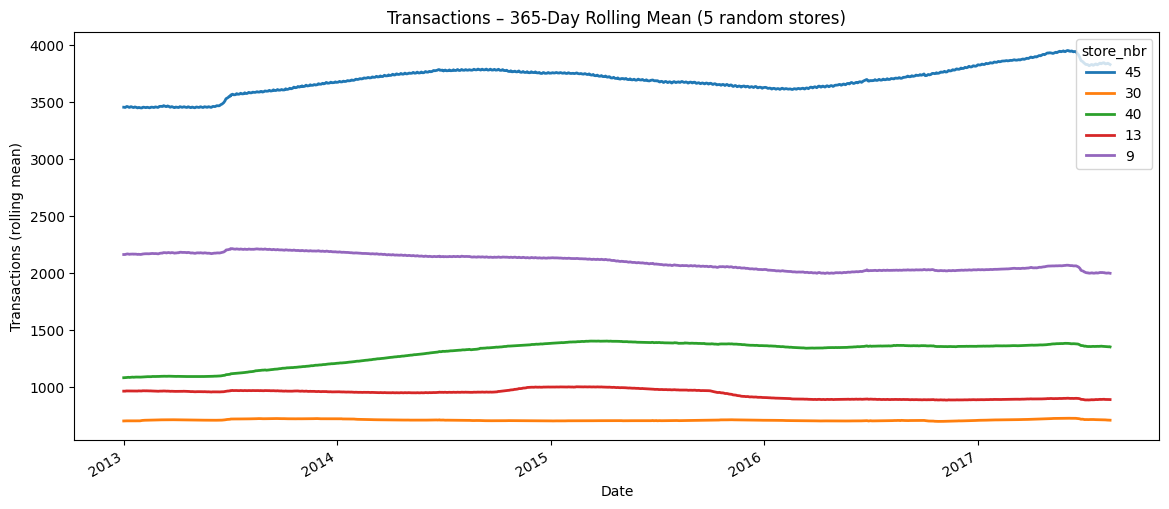

In [52]:
# Sample 5 random stores
store_cols = transactions.columns  # wide: index=date, columns=store_nbr
rng = np.random.default_rng(42)
sel_stores = store_cols.take(rng.choice(len(store_cols), size=5, replace=False))

# Slice stores
to_plot = transactions.loc[:, sel_stores].copy()
to_plot.index = to_plot.index.to_timestamp()

# 365-day centered rolling mean
ma365 = to_plot.rolling(window=365, center=True, min_periods=183).mean()

# Plot
ax = ma365.plot(figsize=(14, 6), linewidth=2, legend=True)
ax.set_title("Transactions – 365-Day Rolling Mean (5 random stores)")
ax.set_xlabel("Date")
ax.set_ylabel("Transactions (rolling mean)")
plt.show()

### Build wide target (y_tx) and fit trend only

In [53]:
def make_wide_transactions(transactions_df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a wide matrix: index=date (Period[D]), columns=store_nbr, values=transactions.
    Accepts either:
      • long: index has (date, store_nbr) and a 'transactions' column, or
      • wide: index=date, columns=store_nbr (optionally a top-level 'transactions').
    """
    df = transactions_df

    # CASE A: long form in the index
    if isinstance(df.index, pd.MultiIndex) and {"date","store_nbr"} <= set(df.index.names or []):
        if isinstance(df, pd.DataFrame) and "transactions" in df.columns:
            ser = df["transactions"]
        else:
            ser = df.squeeze()
        y_tx = ser.unstack("store_nbr").sort_index()

    else:
        # CASE B: already wide
        y_tx = df.copy()
        # If columns are MultiIndex like ('transactions', store_nbr), slice level 0
        if isinstance(y_tx.columns, pd.MultiIndex) and (y_tx.columns.names or [None])[0] == "transactions":
            y_tx = y_tx.xs("transactions", axis=1, level=0)

    # Ensure daily Period index
    if not isinstance(y_tx.index, pd.PeriodIndex):
        y_tx.index = pd.to_datetime(y_tx.index).to_period("D")

    return y_tx.astype("float32")

y_tx = make_wide_transactions(transactions)
# Deterministic trend (no weekly yet)
X_tx = make_dp(y_tx.index, order=2, weekly=False)

# Split
idx_train_tx = y_tx.index < "2017-01-01"
idx_valid_tx = ~idx_train_tx

# Trend-only Ridge
ridge_trend_tx, study_trend_tx = fit_ridge_with_optuna(
    X_tx.loc[idx_train_tx], y_tx.loc[idx_train_tx],
    X_tx.loc[idx_valid_tx], y_tx.loc[idx_valid_tx],
    alpha_lo=1e3, alpha_hi=1e4, patience=12
)
y_trend_tx = pd.DataFrame(ridge_trend_tx.predict(X_tx), index=y_tx.index, columns=y_tx.columns)

print("Best params:", study_trend_tx.best_params)
print("Best RMSLE:", study_trend_tx.best_value)
print("Best RMSE :", study_trend_tx.best_trial.user_attrs["rmse"])

[I 2025-08-29 00:22:44,500] A new study created in memory with name: no-name-2bdb2889-09cd-445f-9275-957b98bcf8e4
[W 2025-08-29 00:22:44,518] Trial 0 failed with parameters: {'alpha': 2368.863950364079} because of the following error: ValueError('A given column is not a column of the dataframe').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'sin(1,freq=YE-DEC)'

The above exception was the direct cause of the following exception:

Trace

ValueError: A given column is not a column of the dataframe

### Residuals, weekly seasonal plot, and periodogram

In [ ]:
# Residuals
y_resid_tx = (y_tx - y_trend_tx).replace([np.inf, -np.inf], np.nan).dropna(how="all", axis=0)

# Global (median across stores) residual
resid_median_tx = y_resid_tx.median(axis=1).dropna()
t_tx = resid_median_tx.index.to_timestamp()

# Weekly seasonal plot on residuals
X_week_tx = pd.DataFrame(
    {
        "week": t_tx.isocalendar().week.astype(int).to_numpy(),
        "day": t_tx.dayofweek.to_numpy(),
        "resid": resid_median_tx.to_numpy(),
    },
    index=t_tx,
)
seasonal_plot(X_week_tx, y="resid", period="week", freq="day")

# Periodogram of residuals (don’t double-detrend)
_ = plot_periodogram(resid_median_tx, detrend="constant")

### Fit trend + seasonality, keep seasonal DP as the base design

In [ ]:
# Fourier + weekly seasonal DP
X_seasonal_tx, X_tx_forecast = make_dp(
    y_tx.index, order=2, weekly=True, fourier_order=12, forecast=16)
ridge_seas_tx, study_seas_tx = fit_ridge_with_optuna(
    X_seasonal_tx.loc[idx_train_tx], y_tx.loc[idx_train_tx],
    X_seasonal_tx.loc[idx_valid_tx], y_tx.loc[idx_valid_tx],
    alpha_lo=1e3, alpha_hi=1e4, patience=12
)
y_trend_tx = pd.DataFrame(ridge_seas_tx.predict(X_seasonal_tx), index=y_tx.index, columns=y_tx.columns)
X_tx = X_seasonal_tx

print("Best params:", study_seas_tx.best_params)
print("Best RMSLE:", study_seas_tx.best_value)
print("Best RMSE :", study_seas_tx.best_trial.user_attrs["rmse"])

### Incorporate National Events

In [ ]:
# national_events index: Period[D]
X_tx = X_tx.join(national_events, how="left").fillna(0.0)

# Refit with holidays to capture their effect
ridge_hol_tx, study_hol_tx = fit_ridge_with_optuna(
    X_tx.loc[idx_train_tx], y_tx.loc[idx_train_tx],
    X_tx.loc[idx_valid_tx], y_tx.loc[idx_valid_tx],
    alpha_lo=1e3, alpha_hi=1e4, patience=12
)
y_trend_tx = pd.DataFrame(ridge_hol_tx.predict(X_tx), index=y_tx.index, columns=y_tx.columns)

print("Best params:", study_hol_tx.best_params)
print("Best RMSLE:", study_hol_tx.best_value)
print("Best RMSE :", study_hol_tx.best_trial.user_attrs["rmse"])

### PACF on residuals (to choose lags)

In [ ]:
# Recompute residuals after holidays
y_resid_tx = (y_tx - y_trend_tx).replace([np.inf, -np.inf], np.nan).dropna(how="all", axis=0)

# Global standardized residual mean for PACF
def zscore_cols(df: pd.DataFrame) -> pd.DataFrame:
    mu = df.mean(axis=0)
    sd = df.std(axis=0, ddof=0).replace(0, np.nan)
    return (df - mu) / sd

global_tx_cycle = zscore_cols(y_resid_tx).mean(axis=1).dropna()
_ = plot_lags(global_tx_cycle, lags=12, nrows=2)
_ = plot_pacf(global_tx_cycle, lags=20)

### Add transaction lags to features and train the full model

In [ ]:
# Choose lags (adjust after PACF review)
L_TX = 14

# Build lags on the wide matrix (returns MultiIndex columns → flatten)
tx_lags = make_lags(y_tx, lags=L_TX, name="tx")
tx_lags.columns = tx_lags.columns.to_flat_index()
tx_lags.columns = tx_lags.columns.astype(str)

# Join to design
X_tx_full = X_tx.join(tx_lags, how="left")

# Final Ridge with larger alpha search (stabilizes many lags)
ridge_full_tx, study_full_tx = fit_ridge_with_optuna(
    X_tx_full.loc[idx_train_tx], y_tx.loc[idx_train_tx],
    X_tx_full.loc[idx_valid_tx], y_tx.loc[idx_valid_tx],
    alpha_lo=1e2, alpha_hi=1e5, patience=12
)

# In-sample predictions to inspect fit; valid metrics
y_pred_tx = pd.DataFrame(ridge_full_tx.predict(X_tx_full), index=y_tx.index, columns=y_tx.columns)

print("Best params:", study_full_tx.best_params)
print("Best RMSLE (valid):", study_full_tx.best_value)
print("Best RMSE  (valid):", study_full_tx.best_trial.user_attrs["rmse"])

TX_BASE_COLS  = X_tx_full.columns.astype(str).tolist()
TX_BASE_DTYPES = {c: 'float32' for c in TX_BASE_COLS}

### Forecast 16 days of Transactions

In [ ]:
def lags_row_for_date(
    wide_df: pd.DataFrame,
    date,
    lags: int,
    name: str,
    log1p: bool = False
) -> pd.DataFrame:

    # Make tmp copy of dataframe
    df = wide_df.copy()

    # Add date to index
    if date not in df.index:
        df.loc[date] = np.nan

    # build full set of lags on the *whole* history and take only the last row
    lagged = make_lags(df, lags=lags, name=name)

    # flatten to strings identical to training
    lagged.columns = lagged.columns.to_flat_index()

    # Apply optional transform
    if log1p:
        return np.log1p(lagged.loc[[date]])

    return lagged.loc[[date]]

In [ ]:
tx_hist = transactions.copy()  # your rolling history, wide with store columns

for date in X_tx_forecast.index:
    # Base deterministics for this day
    X_test_tx = X_tx_forecast.loc[[date]].join(national_events, how="left").fillna(0.0)

    # ⬅️ recompute *flattened* lag row (matches training names 1:1)
    tx_lags_row = lags_row_for_date(tx_hist, date=date, lags=L_TX, name="tx")

    # Concatenate along columns (avoids MultiIndex merge issues)
    X_test_tx = pd.concat([X_test_tx, tx_lags_row], axis=1)

    # Stringify and reindex to the training column space
    X_test_tx.columns = X_test_tx.columns.astype(str)
    X_test_tx = X_test_tx.reindex(columns=TX_BASE_COLS, fill_value=0).astype("float32")

    # (optional) probe — catches any drift immediately
    assert list(X_test_tx.columns) == TX_BASE_COLS, "TX columns/order mismatch."

    # Predict one day of transactions (wide per-store row)
    tx_pred_next = pd.DataFrame(
        ridge_full_tx.predict(X_test_tx),
        index=X_test_tx.index,
        columns=tx_hist.columns
    )

    # Roll history forward for the next day's lags
    tx_hist = pd.concat([tx_hist, tx_pred_next])

In [ ]:
# sanity: all these should be daily PeriodIndex
assert isinstance(y_tx.index, pd.PeriodIndex) and y_tx.index.freqstr == "D"
assert isinstance(transactions.index, pd.PeriodIndex) and transactions.index.freqstr == "D"
assert isinstance(X_tx_forecast.index, pd.PeriodIndex) and X_tx_forecast.index.freqstr == "D"

In [ ]:
tx_hist.tail()

## Predict `y_pred_test`

In [ ]:
def hybrid_predict_one_day(
    X_test,
    model_1,
    model_2,
    stores,
    local_holidays,
    regional_holidays,
    onp_long,
    BASELINE_COLS,
    RESIDUAL_COLS,
    FAMILY_CATS,
    STORE_CATS
):
    # --- Baseline prediction (wide) ------------------------------------------
    Xb = X_test.reindex(columns=BASELINE_COLS, fill_value=0).astype('float32')
    y_pred_1 = pd.DataFrame(model_1.predict(Xb), index=Xb.index, columns=y.columns)
    
    # --- Build residual features X2 for this date ----------------------------
    X2 = (
        y_pred_1
        .stack(['store_nbr','family'])
        .rename('sales')
        .reset_index()        # columns: date, store_nbr, family, sales
        .drop(columns=['sales'])
        .set_index('date')
    )

    # Store metadata
    X2 = X2.join(stores, on='store_nbr', how='left')

    # Local holidays
    X2 = (
        X2.reset_index()
          .merge(local_holidays.reset_index(), on=['date','city'], how='left', validate='many_to_one')
          .set_index('date')
          .drop(columns='city')
          .fillna({'additional':0.0, 'additional_squared':0.0, 'local_holiday':0.0})
    )

    # Regional
    X2 = (
        X2.reset_index()
          .merge(regional_holidays.reset_index(), on=['date','state'], how='left', validate='many_to_one')
          .set_index('date')
          .drop(columns='state')
          .fillna({'regional_holiday':0.0})
    )

    
    # Categorical domains -> deterministic one-hot
    # 1) cast categorical domains so get_dummies sees the full space
    X2 = X2.reset_index()
    X2['family']    = X2['family'].astype(pd.CategoricalDtype(categories=FAMILY_CATS))
    X2['store_nbr'] = X2['store_nbr'].astype(pd.CategoricalDtype(categories=STORE_CATS))
    X2['type']     = X2['type'].astype(pd.CategoricalDtype(categories=TYPE_CATS))
    X2['cluster']  = X2['cluster'].astype('category')  # numeric is fine too
    
    # 2) build dummies WITHOUT drop_first (we'll align later)
    fam_oh   = pd.get_dummies(X2['family'],    dtype='float32')
    store_oh = pd.get_dummies(X2['store_nbr'], prefix='store_nbr_', dtype='float32')
    type_oh  = pd.get_dummies(X2['type'],      prefix='type_',      dtype='float32')
    clus_oh  = pd.get_dummies(X2['cluster'],   prefix='cluster',    dtype='float32')
    
    X2 = pd.concat([X2.drop(columns=['type','cluster'], errors='ignore'),
                    fam_oh, store_oh, type_oh, clus_oh], axis=1)
    
    # back to the 3-level index
    X2 = X2.set_index(['date','store_nbr','family']).sort_index()

    # onpromotion compact features
    X2 = (
        X2.reset_index()
          .merge(onp_long.reset_index(), on=['date','store_nbr','family'], how='left', validate='many_to_one')
          .set_index(['date','store_nbr','family'])
    )
    
    # 3) reindex to the exact training columns + order
    X2 = X2.reindex(columns=RESIDUAL_COLS, fill_value=0).astype('float32')

    # --- Residual prediction and hybrid --------------------------------------
    y1_long = (
        y_pred_1
        .stack(['store_nbr','family'])
        .rename('Baseline')
        .reorder_levels(['date','store_nbr','family'])
        .sort_index()
    )

    y2_pred = pd.Series(model_2.predict(X2), index=X2.index, name='Res2')
    y_pred_long = (y1_long.loc[y2_pred.index] + y2_pred).rename('sales').clip(lower=0)

    # Wide (columns MultiIndex like training y)
    y_pred_df = y_pred_long.unstack(['store_nbr','family'])
    return y_pred_df

In [ ]:
# Bring in forecast from our seasonality training
X_forecast.index.name='date'
X_forecast.head()

In [ ]:
# Add compact onpromotion features for Test
onp_long = pd.concat([onp_long, create_onpromo_feat(test)])

In [ ]:
y_pred_test_list = []
y_hist = y.copy()  # start from train truth
for date in X_forecast.index:  
    X_test = X_forecast.loc[[date]].join(national_events, how='left').fillna(0.0)

    # y-lags for this date (RAW; matches training)
    y_lags_row  = lags_row_for_date(y_hist, date, lags=9, name="y",  log1p=False)

    # tx-lags for this date (LOG1P; matches training of the baseline sales model)
    tx_lags_row = lags_row_for_date(tx_hist, date, lags=9, name="tx", log1p=True)

    # Join & tidy
    X_test = X_test.join(y_lags_row,  how="left")
    X_test = X_test.join(tx_lags_row, how="left")
    X_test = X_test.join(oil_feats,    how="left").fillna(0.0)  # shared exogenous
    X_test.columns = X_test.columns.astype(str)

    # Predict this day
    y_pred_next = hybrid_predict_one_day(
        X_test, ridge_full, final_model,
        stores, local_holidays, regional_holidays, onp_long,
        BASELINE_COLS, RESIDUAL_COLS, FAMILY_CATS, STORE_CATS
    )
    y_pred_test_list.append(y_pred_next)

    # Roll the history forward so the next day's *y* lags use today's prediction
    y_hist = pd.concat([y_hist, y_pred_next])

y_pred_test = pd.concat(y_pred_test_list).sort_index()

In [ ]:
# Sanity checks
want = test.index.to_frame(index=False).set_index(['date','store_nbr','family']).index
have = y_pred_test.stack(['store_nbr','family']).index

missing = want.difference(have)
extra   = have.difference(want)
print("Missing:", len(missing), "Extra:", len(extra))
assert len(missing)==0 and len(extra)==0, "Index mismatch train→test."

s = y_pred_test.stack(['store_nbr','family']).astype('float64')
assert np.isfinite(s).all() and (s>=0).all(), "Found NaN/Inf/negative in predictions."

In [ ]:
# --- Normalize y_pred_test to avoid the old 'sales' level trap ---
if isinstance(y_pred_test, pd.DataFrame) and isinstance(y_pred_test.columns, pd.MultiIndex):
    # If a stray top-level 'sales' exists, drop it
    for lvl in range(y_pred_test.columns.nlevels):
        if 'sales' in y_pred_test.columns.get_level_values(lvl):
            y_pred_test = y_pred_test.xs('sales', axis=1, level=lvl, drop_level=True)
            break

# Stack to long and NAME the values 'sales'
pred_long = (
    y_pred_test
    .stack(['store_nbr','family'])
    .astype('float64')
    .rename('sales')
)

# sanity checks
assert pred_long.index.names == ['date','store_nbr','family']
assert str(test.reset_index()['date'].dtype) == 'period[D]'
assert pred_long.index.get_level_values('date').dtype == 'period[D]'

In [ ]:
sub = (
    test.reset_index()
        .merge(pred_long.reset_index(), on=['date','store_nbr','family'], how='left')
        .assign(sales=lambda d: d['sales'].fillna(0.0).clip(lower=0))
        [['id','sales']]
)
sub.sort_values(by='id').to_csv('submission.csv', index=False)

In [ ]:
zero_share = (sub['sales'] == 0).mean()
print("Zero share:", zero_share)

In [ ]:
sub['sales'].describe(percentiles=[.5, .9, .99, .999])
